# 📊 Pipeline d'Analyse Complète des Images Raman
## Clustering Multi-Paramètres (Taille × Forme × Intensité)

**Projet**: Analyse morphologique et chimique de particules via spectroscopie 

---
### 📋 Sections du Notebook
1. ✅ Import des Bibliothèques et Chargement de l'Image
2. 📊 Évaluation de la Qualité de l'Image
3. 🔬 Prétraitement et Segmentation par Intensité
4. 🔍 Détection et Extraction des Particules
5. 🎯 Clustering Multi-Paramètres (Taille × Forme × Intensité)
6. 📐 Clustering 3D et Classification Physique
7. 📈 Analyse PCA et Réduction Dimensionnelle
8. 🏆 Identification de la Zone Équilibrée Représentative
9. 📊 Visualisations Avancées et Heatmaps
10. 📋 Rapport Final et Sauvegarde des Résultats

## 1️⃣ Import des Bibliothèques et Chargement de l'Image

In [57]:
# Import des bibliothèques essentielles
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from scipy.stats import entropy
from scipy.ndimage import gaussian_filter
import warnings
warnings.filterwarnings('ignore')

print("✓ Toutes les bibliothèques importées avec succès")

✓ Toutes les bibliothèques importées avec succès


In [58]:
# Charger l'image Raman
image_path = "C:\\Users\\marwa\\OneDrive\\Desktop\\Analyse_Raman\\Image_RAMA\\raman_project\\results\\focus_stacking\\Poudre_Compactee_Test_1_X50_20img_928x624px.jpg"
img = cv2.imread(image_path)
if img is not None:
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
else:
    raise FileNotFoundError(f"L'image n'a pas pu être chargée: {image_path}")

print(f"📷 Image chargée: {gray.shape}")
print(f"   Dimensions: {img_rgb.shape[1]} × {img_rgb.shape[0]} pixels")
print(f"   Type de données: {gray.dtype}")

📷 Image chargée: (624, 928)
   Dimensions: 928 × 624 pixels
   Type de données: uint8


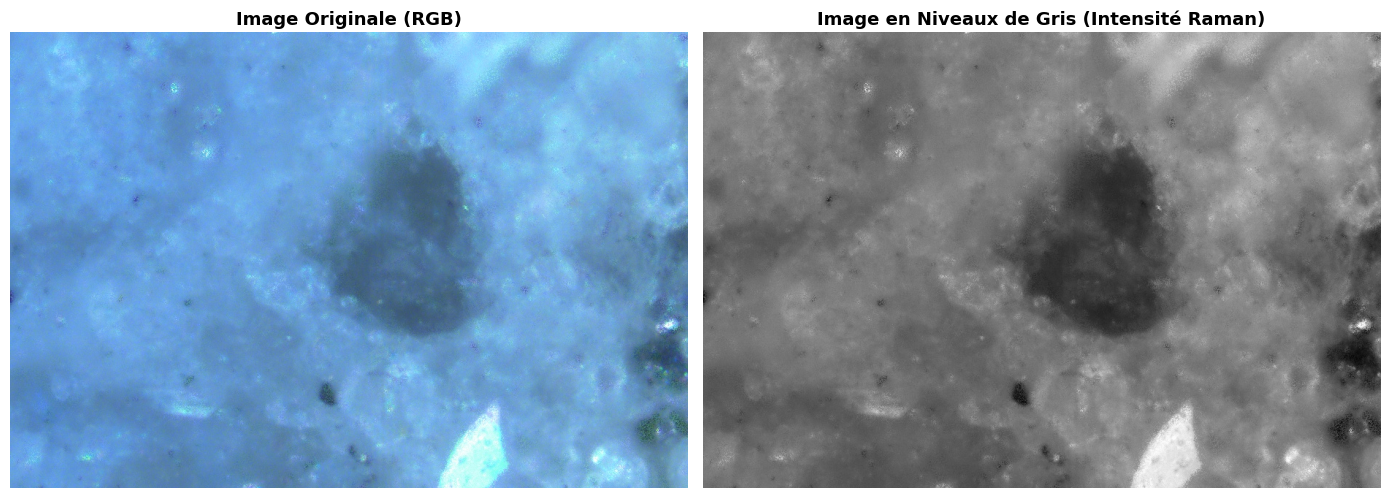

✓ Image affichée pour validation


In [59]:
# Affichage côte à côte
plt.figure(figsize=(14, 6))

# image originale en RGB
plt.subplot(1, 2, 1)
plt.imshow(img_rgb)
plt.title("Image Originale (RGB)", fontsize=13, fontweight='bold')
plt.axis("off")

# image originale en niveaux de gris
plt.subplot(1, 2, 2)
plt.imshow(gray, cmap="gray")
plt.title("Image en Niveaux de Gris (Intensité Raman)", fontsize=13, fontweight='bold')
plt.axis("off")

plt.tight_layout()
plt.show()

print("✓ Image affichée pour validation")

## 2️⃣ Évaluation de la Qualité de l'Image

In [60]:
print("\n📊 QUALITÉ DE L'IMAGE (avant prétraitement):")
print("="*70)

# Métrique 1: Contraste
contrast = np.std(gray)
print(f"  • Contraste (écart-type): {contrast:.2f}")

# Métrique 2: Plage dynamique (de 0 à 255)
dynamic_range = gray.max() - gray.min()
print(f"  • Plage dynamique: {dynamic_range} (min: {gray.min()}, max: {gray.max()})")

# Métrique 3: Netteté (variance du Laplacien)
laplacian = cv2.Laplacian(gray, cv2.CV_64F)
sharpness = laplacian.var()
print(f"  • Netteté (variance Laplacien): {sharpness:.2f}")

# Métrique 4: Rapport signal/bruit estimé (SNR)
mean_intensity = gray.mean()
std_intensity = gray.std()
snr_estimate = mean_intensity / std_intensity if std_intensity > 0 else 0
print(f"  • SNR estimé: {snr_estimate:.2f}")

# Métrique 5: Entropie (niveau d'information)
hist, _ = np.histogram(gray.ravel(), bins=256, range=(0, 256))
hist_normalized = hist / hist.sum()
image_entropy = entropy(hist_normalized + 1e-10)
print(f"  • Entropie: {image_entropy:.2f}")

# Métrique 6: Coefficient de variation (CV)
cv = (std_intensity / mean_intensity) * 100 if mean_intensity > 0 else 0
print(f"  • Coefficient de variation: {cv:.2f}%")

print(f"\n✓ Qualité image évaluée")


📊 QUALITÉ DE L'IMAGE (avant prétraitement):
  • Contraste (écart-type): 22.65
  • Plage dynamique: 201 (min: 54, max: 255)
  • Netteté (variance Laplacien): 297.35
  • SNR estimé: 6.50
  • Entropie: 4.45
  • Coefficient de variation: 15.39%

✓ Qualité image évaluée


## 3️⃣ Prétraitement et Segmentation par Intensité

In [61]:
# Amélioration du contraste avec algorithme de CLAHE (Contrast Limited Adaptive Histogram Equalization)
clahe = cv2.createCLAHE(clipLimit=2.5, tileGridSize=(8, 8))
gray_eq = clahe.apply(gray)

print("✓ Contraste amélioré avec CLAHE")

# Définir les seuils d'intensité (conventionnels)
thresh1 = 85    # Seuil Noir-Gris
thresh2 = 170   # Seuil Gris-Blanc

# Créer les masques (booléens) pour chaque type
mask_type3 = gray_eq < thresh1
mask_type2 = (gray_eq >= thresh1) & (gray_eq < thresh2)
mask_type1 = gray_eq >= thresh2

print(f"\n🔬 Segmentation par Intensité:")
print(f"  Type 1 (Blanc, {thresh2}-255): {np.sum(mask_type1):7d} pixels ({100*np.sum(mask_type1)/gray.size:5.1f}%)")
print(f"  Type 2 (Gris,  {thresh1}-{thresh2-1}): {np.sum(mask_type2):7d} pixels ({100*np.sum(mask_type2)/gray.size:5.1f}%)")
print(f"  Type 3 (Noir,  0-{thresh1-1}): {np.sum(mask_type3):7d} pixels ({100*np.sum(mask_type3)/gray.size:5.1f}%)")

✓ Contraste amélioré avec CLAHE

🔬 Segmentation par Intensité:
  Type 1 (Blanc, 170-255):  109890 pixels ( 19.0%)
  Type 2 (Gris,  85-169):  432688 pixels ( 74.7%)
  Type 3 (Noir,  0-84):   36494 pixels (  6.3%)


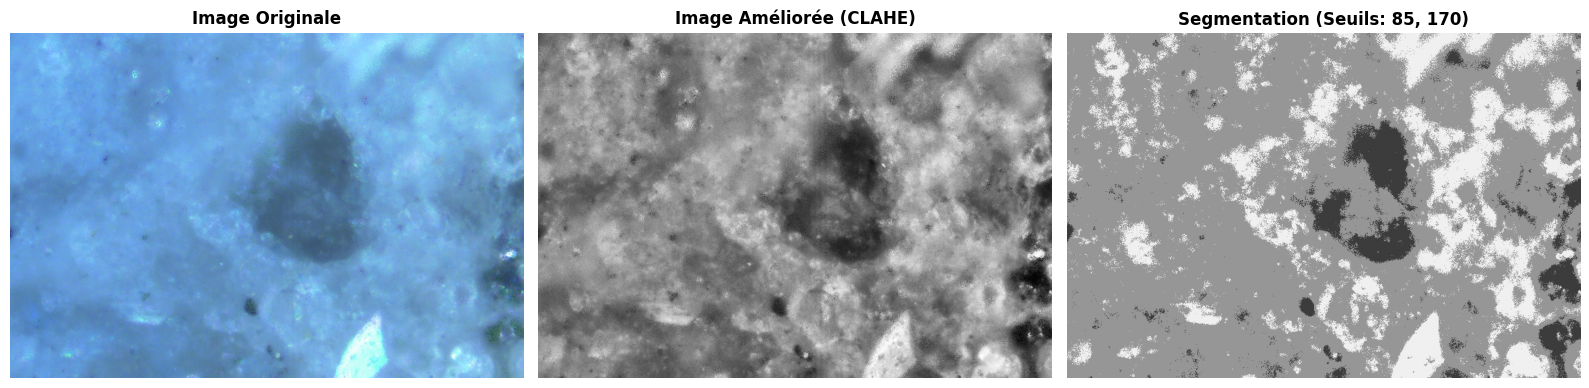

✓ Segmentation visualisée


In [62]:
# Visualiser la segmentation
segmentation_img = np.zeros_like(gray_eq)
segmentation_img[mask_type1] = 240  # Blanc
segmentation_img[mask_type2] = 150  # Gris
segmentation_img[mask_type3] = 60   # Noir

fig, axes = plt.subplots(1, 3, figsize=(16, 5))

# Affichage des images
# image originale en RGB
axes[0].imshow(img_rgb)
axes[0].set_title('Image Originale', fontsize=12, fontweight='bold')
axes[0].axis('off')

# image améliorée avec CLAHE
axes[1].imshow(gray_eq, cmap='gray')
axes[1].set_title('Image Améliorée (CLAHE)', fontsize=12, fontweight='bold')
axes[1].axis('off')

# image segmentée
axes[2].imshow(segmentation_img, cmap='gray', vmin=0, vmax=255)
axes[2].set_title(f'Segmentation (Seuils: {thresh1}, {thresh2})', fontsize=12, fontweight='bold')
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("✓ Segmentation visualisée")

## 4️⃣ Détection et Extraction des Particules

In [63]:
# Détecter et extraire les features des particules dans chaque masque
def detect_particles_in_mask(mask, type_name, min_area=5):
    """Détecter et extraire les features des particules dans un masque"""
    mask_uint8 = (mask * 255).astype(np.uint8)
    kernel = np.ones((2, 2), np.uint8)
    mask_clean = cv2.morphologyEx(mask_uint8, cv2.MORPH_OPEN, kernel, iterations=1)
    contours, _ = cv2.findContours(mask_clean, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    
    features = []
    valid_contours = []
    
    for cnt in contours:
        area = cv2.contourArea(cnt)
        if area < min_area:
            continue
        
        # Extraire les features
        perimeter = cv2.arcLength(cnt, True)
        circularity = (4 * np.pi * area) / (perimeter**2 + 1e-6)
        
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h if h > 0 else 0
        
        hull = cv2.convexHull(cnt)
        hull_area = cv2.contourArea(hull)
        solidity = area / hull_area if hull_area > 0 else 0
        
        mask_particle = np.zeros_like(gray_eq, dtype=np.uint8)
        cv2.drawContours(mask_particle, [cnt], -1, 255, -1)
        mean_intensity = cv2.mean(gray_eq, mask=mask_particle)[0]
        
        # Calculer le centroïde
        M = cv2.moments(cnt)
        if M['m00'] > 0:
            center_x = int(M['m10'] / M['m00'])
            center_y = int(M['m01'] / M['m00'])
        else:
            center_x = x + w // 2
            center_y = y + h // 2
        
        features.append({
            'Type': type_name,
            'Area_px2': area,
            'Perimeter_px': perimeter,
            'Circularity': circularity,
            'AspectRatio': aspect_ratio,
            'Solidity': solidity,
            'MeanIntensity': mean_intensity,
            'Center_X': center_x,
            'Center_Y': center_y
        })
        valid_contours.append(cnt)
    
    print(f"  {type_name}: {len(valid_contours)} particules détectées")
    return features, valid_contours

print("🔍 Détection des particules par type...\n")

features_type1, contours_type1 = detect_particles_in_mask(mask_type1, 'Type_1_Blanc')
features_type2, contours_type2 = detect_particles_in_mask(mask_type2, 'Type_2_Gris')
features_type3, contours_type3 = detect_particles_in_mask(mask_type3, 'Type_3_Noir')

# Créer DataFrame consolidé
all_features = features_type1 + features_type2 + features_type3
df_particles = pd.DataFrame(all_features)

print(f"\n✓ Total particules détectées: {len(df_particles)}")

🔍 Détection des particules par type...

  Type_1_Blanc: 242 particules détectées
  Type_2_Gris: 46 particules détectées
  Type_3_Noir: 60 particules détectées

✓ Total particules détectées: 348


In [64]:
# Statistiques par type
print("\n📊 STATISTIQUES PAR TYPE D'INTENSITÉ:")
print("="*70)

for type_name in ['Type_1_Blanc', 'Type_2_Gris', 'Type_3_Noir']:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        print(f"\n{type_name}:")
        print(f"  Nombre de particules:     {len(df_type)}")
        print(f"  Surface moyenne:          {df_type['Area_px2'].mean():.1f} ± {df_type['Area_px2'].std():.1f} px²")
        print(f"  Circularité moyenne:      {df_type['Circularity'].mean():.3f} ± {df_type['Circularity'].std():.3f}")
        print(f"  Solidité moyenne:         {df_type['Solidity'].mean():.3f}")
        print(f"  Intensité moyenne:        {df_type['MeanIntensity'].mean():.1f}/255")


📊 STATISTIQUES PAR TYPE D'INTENSITÉ:

Type_1_Blanc:
  Nombre de particules:     242
  Surface moyenne:          315.8 ± 1074.7 px²
  Circularité moyenne:      0.352 ± 0.202
  Solidité moyenne:         0.673
  Intensité moyenne:        177.9/255

Type_2_Gris:
  Nombre de particules:     46
  Surface moyenne:          11365.7 ± 76657.6 px²
  Circularité moyenne:      0.431 ± 0.200
  Solidité moyenne:         0.739
  Intensité moyenne:        147.3/255

Type_3_Noir:
  Nombre de particules:     60
  Surface moyenne:          456.2 ± 1423.2 px²
  Circularité moyenne:      0.398 ± 0.194
  Solidité moyenne:         0.727
  Intensité moyenne:        77.0/255


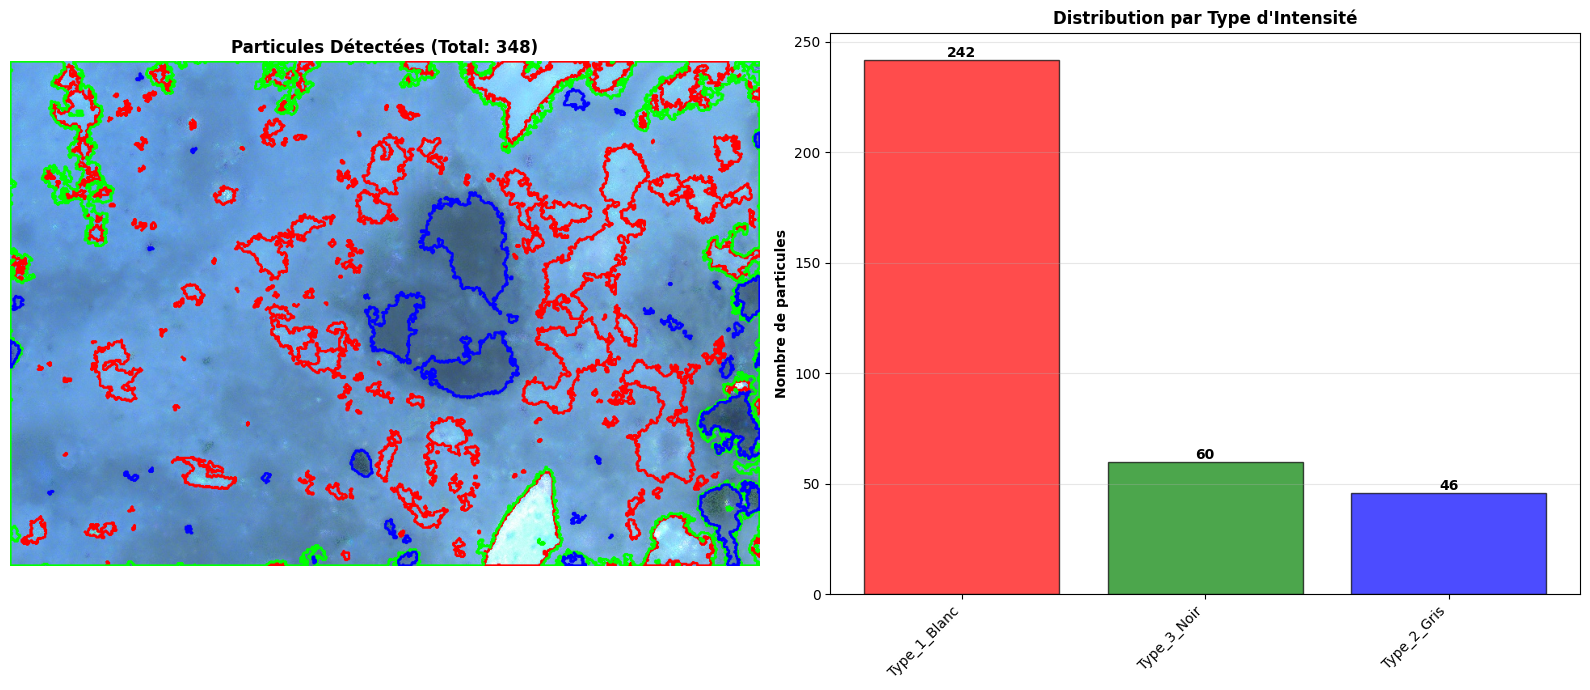

✓ Particules détectées et visualisées


In [65]:
# Visualiser les particules détectées
overlay = img_rgb.copy()
for cnt in contours_type1:
    cv2.drawContours(overlay, [cnt], -1, (255, 0, 0), 2)  # Bleu
for cnt in contours_type2:
    cv2.drawContours(overlay, [cnt], -1, (0, 255, 0), 2)  # Vert
for cnt in contours_type3:
    cv2.drawContours(overlay, [cnt], -1, (0, 0, 255), 2)  # Rouge

fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(overlay)
axes[0].set_title(f'Particules Détectées (Total: {len(df_particles)})', fontsize=12, fontweight='bold')
axes[0].axis('off')

type_counts = df_particles['Type'].value_counts()
colors = ['red', 'green', 'blue']
axes[1].bar(range(len(type_counts)), type_counts.values, color=colors[:len(type_counts)], 
           edgecolor='black', alpha=0.7)
axes[1].set_xticks(range(len(type_counts)))
axes[1].set_xticklabels(type_counts.index, rotation=45, ha='right')
axes[1].set_ylabel('Nombre de particules', fontweight='bold')
axes[1].set_title('Distribution par Type d\'Intensité', fontsize=12, fontweight='bold')
axes[1].grid(True, alpha=0.3, axis='y')

for i, v in enumerate(type_counts.values):
    axes[1].text(i, v, str(v), ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("✓ Particules détectées et visualisées")

## 5️⃣ Clustering Multi-Paramètres (Taille × Forme × Intensité)

In [66]:
print("\n🎯 CLUSTERING COMBINÉ: TAILLE × FORME × INTENSITÉ")
print("="*70)

if len(df_particles) >= 5:
    # Créer les scores combinés
    df_particles['Size_Score'] = df_particles['Area_px2']
    df_particles['Shape_Score'] = (
        df_particles['Circularity'] * 0.4 + 
        df_particles['Solidity'] * 0.4 + 
        (1 / (1 + df_particles['AspectRatio'])) * 0.2
    )
    df_particles['Intensity_Score'] = df_particles['MeanIntensity']
    
    print("\n📊 Étape 1: Préparation des features combinées...")
    print(f"  ✓ Size_Score (Surface): min={df_particles['Size_Score'].min():.1f}, max={df_particles['Size_Score'].max():.1f}")
    print(f"  ✓ Shape_Score (Forme): min={df_particles['Shape_Score'].min():.3f}, max={df_particles['Shape_Score'].max():.3f}")
    print(f"  ✓ Intensity_Score: min={df_particles['Intensity_Score'].min():.1f}, max={df_particles['Intensity_Score'].max():.1f}")


🎯 CLUSTERING COMBINÉ: TAILLE × FORME × INTENSITÉ

📊 Étape 1: Préparation des features combinées...
  ✓ Size_Score (Surface): min=5.0, max=519978.5
  ✓ Shape_Score (Forme): min=0.256, max=0.859
  ✓ Intensity_Score: min=48.9, max=216.0



🔬 Étape 2: Clustering principal multi-paramètres...
🎯 Objectif: Identifier 6-10 types de particules basés sur Intensité × Taille × Forme

🔎 Recherche automatique k optimal sur [6, 10]...
   Critères: Silhouette (qualité) + Inertie (compacité)

   k= 6 → Silhouette: 0.362 | Inertie:    431.2
   k= 7 → Silhouette: 0.328 | Inertie:    365.6
   k= 8 → Silhouette: 0.332 | Inertie:    329.8
   k= 9 → Silhouette: 0.291 | Inertie:    299.7
   k=10 → Silhouette: 0.295 | Inertie:    275.4

  ✓ k optimal: 10 | Score combiné: 0.507
    → Silhouette: 0.295
    → Inertie normalisée: 1.000


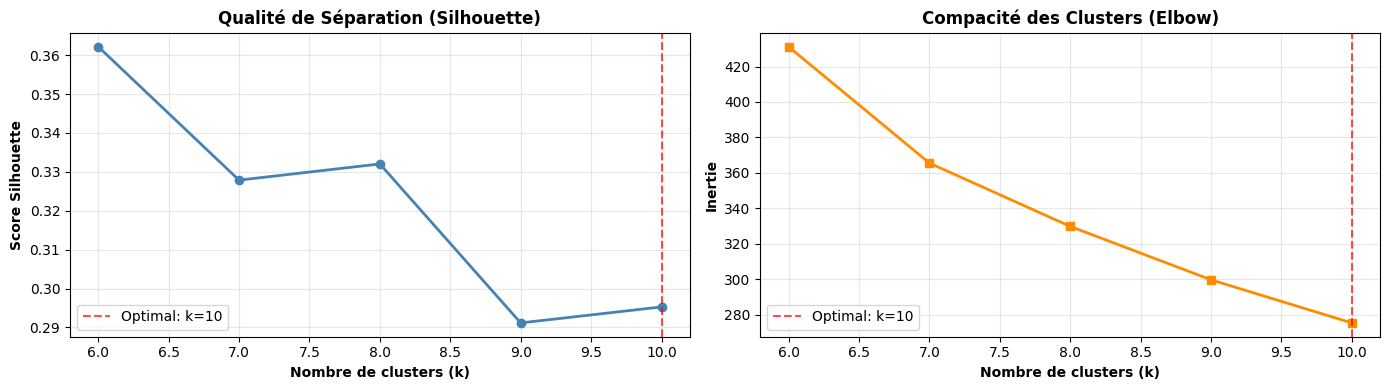


  ✓ 10 clusters créés (typologie physico-réaliste)

  📊 Répartition par cluster:
    Cluster 0:  41 particules ( 11.8%)
    Cluster 1:  50 particules ( 14.4%)
    Cluster 2:  35 particules ( 10.1%)
    Cluster 3:   1 particules (  0.3%)
    Cluster 4:  63 particules ( 18.1%)
    Cluster 5:  20 particules (  5.7%)
    Cluster 6:  68 particules ( 19.5%)
    Cluster 7:  38 particules ( 10.9%)
    Cluster 8:  17 particules (  4.9%)
    Cluster 9:  15 particules (  4.3%)


In [67]:
# Clustering avec KMeans - Optimisé pour 6-12 clusters (typologie physico-réaliste)
print("\n🔬 Étape 2: Clustering principal multi-paramètres...")
print("🎯 Objectif: Identifier 6-10 types de particules basés sur Intensité × Taille × Forme")

feature_cols = ['Size_Score', 'Circularity', 'AspectRatio', 'Solidity', 'Intensity_Score']
X = df_particles[feature_cols].values

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Pondération : Intensité et Taille prioritaires (critères physiques)
weights = np.array([1.3, 1.0, 0.9, 1.0, 1.4])  # [Taille, Circ, Aspect, Solid, Intensité]
X_weighted = X_scaled * weights

# Sélection automatique dans la plage physiquement réaliste 6-10 (optimalement 8-10)
if len(df_particles) >= 12:
    k_min = 6  # Minimum pour capturer la diversité
    k_max = min(10, len(df_particles) - 1)  # Maximum réaliste
    
    silhouette_scores = {}
    inertia_scores = {}
    
    print(f"\n🔎 Recherche automatique k optimal sur [{k_min}, {k_max}]...")
    print("   Critères: Silhouette (qualité) + Inertie (compacité)\n")
    
    for k in range(k_min, k_max + 1):
        km = KMeans(n_clusters=k, random_state=42, n_init=50, max_iter=500)
        labels = km.fit_predict(X_weighted)
        
        # Score de silhouette (qualité de séparation)
        sil_score = silhouette_score(X_weighted, labels)
        silhouette_scores[k] = sil_score
        
        # Inertie (compacité des clusters)
        inertia_scores[k] = km.inertia_
        
        print(f"   k={k:2d} → Silhouette: {sil_score:.3f} | Inertie: {km.inertia_:8.1f}")
    
    # Normaliser l'inertie pour la combiner avec silhouette
    inertias = np.array(list(inertia_scores.values()))
    norm_inertias = 1 - (inertias - inertias.min()) / (inertias.max() - inertias.min())
    
    # Score combiné: 70% silhouette + 30% inertie normalisée
    combined_scores = {}
    for i, k in enumerate(range(k_min, k_max + 1)):
        combined_scores[k] = 0.7 * silhouette_scores[k] + 0.3 * norm_inertias[i]
    
    # Choisir le meilleur k
    best_k = max(combined_scores, key=combined_scores.get)
    best_combined = combined_scores[best_k]
    
    print(f"\n  ✓ k optimal: {best_k} | Score combiné: {best_combined:.3f}")
    print(f"    → Silhouette: {silhouette_scores[best_k]:.3f}")
    print(f"    → Inertie normalisée: {norm_inertias[best_k - k_min]:.3f}")
    
    # Visualisation rapide des scores
    fig, axes = plt.subplots(1, 2, figsize=(14, 4))
    
    k_vals = list(range(k_min, k_max + 1))
    axes[0].plot(k_vals, [silhouette_scores[k] for k in k_vals], 'o-', color='steelblue', linewidth=2)
    axes[0].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal: k={best_k}')
    axes[0].set_xlabel('Nombre de clusters (k)', fontweight='bold')
    axes[0].set_ylabel('Score Silhouette', fontweight='bold')
    axes[0].set_title('Qualité de Séparation (Silhouette)', fontweight='bold')
    axes[0].grid(True, alpha=0.3)
    axes[0].legend()
    
    axes[1].plot(k_vals, [inertia_scores[k] for k in k_vals], 's-', color='darkorange', linewidth=2)
    axes[1].axvline(best_k, color='red', linestyle='--', alpha=0.7, label=f'Optimal: k={best_k}')
    axes[1].set_xlabel('Nombre de clusters (k)', fontweight='bold')
    axes[1].set_ylabel('Inertie', fontweight='bold')
    axes[1].set_title('Compacité des Clusters (Elbow)', fontweight='bold')
    axes[1].grid(True, alpha=0.3)
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    
    n_main_clusters = best_k
else:
    # Fallback si trop peu de particules
    n_main_clusters = min(9, max(6, len(df_particles) // 10))
    print(f"\n  ⚠️ Peu de particules ({len(df_particles)}), k choisi par heuristique: {n_main_clusters}")

# Clustering final avec le k optimal
kmeans_main = KMeans(n_clusters=n_main_clusters, random_state=42, n_init=100, max_iter=800)
df_particles['Cluster_Combined'] = kmeans_main.fit_predict(X_weighted)

print(f"\n  ✓ {n_main_clusters} clusters créés (typologie physico-réaliste)")
print("\n  📊 Répartition par cluster:")
for i in range(n_main_clusters):
    count = len(df_particles[df_particles['Cluster_Combined'] == i])
    print(f"    Cluster {i}: {count:3d} particules ({100*count/len(df_particles):5.1f}%)")

In [68]:
# Interprétation physique des clusters
print("\n🔍 Étape 3: Interprétation physique des clusters...\n")

def interpret_combined_cluster(cluster_data):
    """Interpréter un cluster basé sur ses 3 dimensions"""
    avg_size = cluster_data['Size_Score'].mean()
    avg_shape = cluster_data['Shape_Score'].mean()  # forme morphologique
    avg_intensity = cluster_data['Intensity_Score'].mean()
    
    if avg_size < 50:
        size_label = "Très_Petites"
    elif avg_size < 150:
        size_label = "Petites"
    elif avg_size < 400:
        size_label = "Moyennes"
    elif avg_size < 1000:
        size_label = "Grandes"
    else:
        size_label = "Très_Grandes"
    
    if avg_shape > 0.75:
        shape_label = "Sphériques"
    elif avg_shape > 0.6:
        shape_label = "Compactes"
    elif avg_shape < 0.4:
        shape_label = "Irrégulières"
    else:
        shape_label = "Intermédiaires"
    
    if avg_intensity < 90:
        intensity_label = "Sombres"
    elif avg_intensity < 160:
        intensity_label = "Grises"
    else:
        intensity_label = "Claires"
    
    return f"{intensity_label}_{size_label}_{shape_label}"

def infer_morphology(cluster_data):
    """Déduire la morphologie dominante d’un cluster"""
    avg_circ = cluster_data['Circularity'].mean()
    avg_ar = cluster_data['AspectRatio'].mean()
    avg_solid = cluster_data['Solidity'].mean()

    if avg_ar >= 3.0:
        return "Fibreuse_filamenteuse"
    if avg_ar >= 2.0:
        return "Allongee_ellipsoidale"
    if avg_circ >= 0.85 and avg_ar <= 1.2 and avg_solid >= 0.85:
        return "Arrondie_spherique"
    if avg_circ >= 0.70 and avg_ar <= 1.4:
        return "Sub_arrondie_ovoide"
    if avg_circ < 0.45 and avg_solid < 0.70:
        return "Fractale_rugueuse"
    if avg_circ < 0.55 and avg_solid >= 0.80:
        return "Cristalline_facettee"
    if avg_solid < 0.60:
        return "Agglomeree_agregee"
    if avg_circ < 0.60 and avg_ar > 1.4:
        return "Anguleuse"
    return "Irreguliere"

cluster_labels = {}
cluster_morphologies = {}

for cluster_id in range(n_main_clusters):
    cluster_data = df_particles[df_particles['Cluster_Combined'] == cluster_id]
    
    if len(cluster_data) > 0:
        label = interpret_combined_cluster(cluster_data)
        morph = infer_morphology(cluster_data)

        cluster_labels[cluster_id] = label
        cluster_morphologies[cluster_id] = morph
        
        print(f"  Cluster {cluster_id}: {label}__{morph} (n={len(cluster_data)})")
        print(f"    ├─ Taille: {cluster_data['Size_Score'].mean():.1f} px²")
        print(f"    ├─ Forma: {cluster_data['Circularity'].mean():.3f}")
        print(f"    ├─ Morphologie: {morph}")
        print(f"    └─ Intensité: {cluster_data['Intensity_Score'].mean():.1f}/255\n")

df_particles['Cluster_Label'] = df_particles['Cluster_Combined'].map(cluster_labels)
df_particles['Cluster_Morphology'] = df_particles['Cluster_Combined'].map(cluster_morphologies)
df_particles['Cluster_Label_With_Morphology'] = (
    df_particles['Cluster_Label'].astype(str) + "__" + df_particles['Cluster_Morphology'].astype(str)
)

df_particles['Cluster_Label'].fillna('Non_Classé', inplace=True)
df_particles['Cluster_Morphology'].fillna('Non_Classé', inplace=True)



🔍 Étape 3: Interprétation physique des clusters...

  Cluster 0: Claires_Grandes_Intermédiaires__Fractale_rugueuse (n=41)
    ├─ Taille: 518.2 px²
    ├─ Forma: 0.299
    ├─ Morphologie: Fractale_rugueuse
    └─ Intensité: 178.7/255

  Cluster 1: Claires_Petites_Compactes__Cristalline_facettee (n=50)
    ├─ Taille: 144.0 px²
    ├─ Forma: 0.549
    ├─ Morphologie: Cristalline_facettee
    └─ Intensité: 175.0/255

  Cluster 2: Sombres_Grandes_Intermédiaires__Fractale_rugueuse (n=35)
    ├─ Taille: 592.0 px²
    ├─ Forma: 0.311
    ├─ Morphologie: Fractale_rugueuse
    └─ Intensité: 76.7/255

  Cluster 3: Grises_Très_Grandes_Intermédiaires__Cristalline_facettee (n=1)
    ├─ Taille: 519978.5 px²
    ├─ Forma: 0.072
    ├─ Morphologie: Cristalline_facettee
    └─ Intensité: 137.4/255

  Cluster 4: Claires_Moyennes_Irrégulières__Fractale_rugueuse (n=63)
    ├─ Taille: 396.0 px²
    ├─ Forma: 0.173
    ├─ Morphologie: Fractale_rugueuse
    └─ Intensité: 175.4/255

  Cluster 5: Sombres_Petit

## 6️⃣ Clustering 3D et Classification Physique

In [69]:
print("\n📐 CLUSTERING 3D DANS L'ESPACE NORMALISÉ")
print("="*70)

# Normaliser les paramètres
df_particles['Size_Normalized'] = (df_particles['Size_Score'] - df_particles['Size_Score'].min()) / \
                                   (df_particles['Size_Score'].max() - df_particles['Size_Score'].min())
df_particles['Shape_Normalized'] = df_particles['Shape_Score']
df_particles['Intensity_Normalized'] = df_particles['Intensity_Score'] / 255.0

# Clustering 3D
X_3d = df_particles[['Size_Normalized', 'Shape_Normalized', 'Intensity_Normalized']].values

n_3d_clusters = min(10, max(7, len(df_particles) // 15))
kmeans_3d = KMeans(n_clusters=n_3d_clusters, random_state=42, n_init=80, max_iter=600)
df_particles['Cluster_3D'] = kmeans_3d.fit_predict(X_3d)

print(f"\n✓ {n_3d_clusters} clusters 3D créés")


📐 CLUSTERING 3D DANS L'ESPACE NORMALISÉ

✓ 10 clusters 3D créés



📊 ANALYSE DES CLUSTERS

✓ Distribution des clusters:
  Total de particules: 348

  Cluster 0:   41 particules ( 11.78%)
  Cluster 1:   50 particules ( 14.37%)
  Cluster 2:   35 particules ( 10.06%)
  Cluster 3:    1 particules (  0.29%)
  Cluster 4:   63 particules ( 18.10%)
  Cluster 5:   20 particules (  5.75%)
  Cluster 6:   68 particules ( 19.54%)
  Cluster 7:   38 particules ( 10.92%)
  Cluster 8:   17 particules (  4.89%)
  Cluster 9:   15 particules (  4.31%)


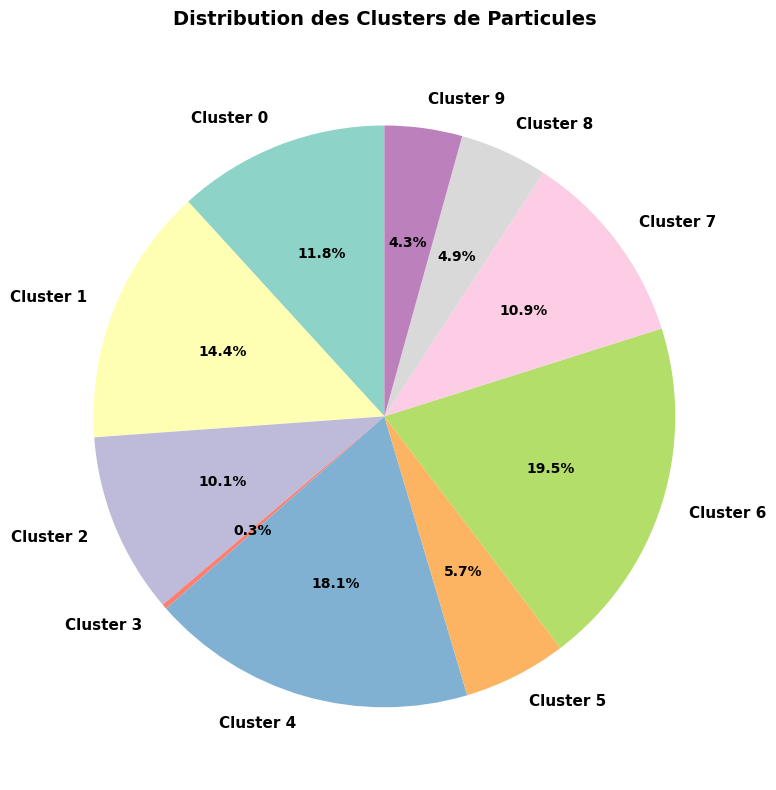


✓ Diagramme circulaire généré et sauvegardé


In [70]:
# Calcul des pourcentages de clusters
print("\n📊 ANALYSE DES CLUSTERS")
print("="*70)

# Créer un alias pour la colonne de cluster
if 'Cluster_Combined' in df_particles.columns:
    df_particles['Cluster'] = df_particles['Cluster_Combined']
elif 'Cluster_3D' in df_particles.columns:
    df_particles['Cluster'] = df_particles['Cluster_3D']

# Compter les occurrences de chaque cluster
cluster_counts = df_particles['Cluster'].value_counts().sort_index()
cluster_percentages = (cluster_counts / len(df_particles) * 100).round(2)

print(f"\n✓ Distribution des clusters:")
print(f"  Total de particules: {len(df_particles)}\n")

for cluster_id in sorted(df_particles['Cluster'].unique()):
    count = cluster_counts[cluster_id]
    percentage = cluster_percentages[cluster_id]
    print(f"  Cluster {cluster_id}: {count:4d} particules ({percentage:6.2f}%)")

# Créer le diagramme circulaire
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(10, 8))

colors = plt.cm.Set3(range(len(cluster_counts)))
wedges, texts, autotexts = ax.pie(
    cluster_counts,
    labels=[f'Cluster {i}' for i in sorted(df_particles['Cluster'].unique())],
    autopct='%1.1f%%',
    colors=colors,
    startangle=90,
    textprops={'fontsize': 11, 'weight': 'bold'}
)

# Améliorer la lisibilité des pourcentages
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(10)
    autotext.set_weight('bold')

ax.set_title('Distribution des Clusters de Particules', fontsize=14, weight='bold', pad=20)

plt.tight_layout()
plt.savefig('cluster_distribution_pie_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✓ Diagramme circulaire généré et sauvegardé")

## 6️⃣.1 Tableaux Croisés et Analyses Détaillées

In [71]:
# # Vérification : Combien de types sont RÉELLEMENT présents dans les données ?
# print("\n✅ VALIDATION : Types physiques réellement présents")
# print("="*70)

# # Compter les particules par type physique
# type_counts = df_particles['Particle_Type_Combined'].value_counts()
# types_presents = len(type_counts)
# types_attendus = 9

# print(f"\n📊 Nombre de types attendus (théorique) : {types_attendus}")
# print(f"🔍 Nombre de types réellement observés   : {types_presents}")

# if types_presents < types_attendus:
#     types_absents = types_attendus - types_presents
#     print(f"⚠️  {types_absents} type(s) absent(s) des données")
    
#     # Lister les types absents
#     tous_types = [
#         "Carbone_Amorphe_Fin", "Carbone_Cristallin_Dense", "Agglomérat_Carbone",
#         "Particule_Transition_Compacte", "Particule_Transition_Anguleuse", "Dépôt_Poreux",
#         "Substrat_Exposé", "Particule_Claire_Compacte", "Bruit_Optique"
#     ]
#     types_observes = set(type_counts.index)
#     types_manquants = [t for t in tous_types if t not in types_observes]
    
#     print(f"\n🚫 Types absents des données actuelles :")
#     for t in types_manquants:
#         print(f"   • {t}")
    
#     print(f"\n💡 Interprétation :")
#     print(f"   → Vos données contiennent {types_presents} types distincts (au lieu de 9)")
#     print(f"   → C'est cohérent avec votre échantillon spécifique")
#     print(f"   → Le clustering a identifié {best_k} groupes mathématiques")

# elif types_presents == types_attendus:
#     print(f"✅ Tous les 9 types théoriques sont présents dans les données")
#     print(f"✅ Le clustering a identifié {best_k} groupes mathématiques")

# # Afficher la distribution
# print(f"\n📈 Distribution des {types_presents} types observés :")
# print(type_counts.to_string())

# # Calculer la cohérence clustering/classification
# print(f"\n🔬 Cohérence clustering (k={best_k}) vs classification ({types_presents} types) :")
# if abs(best_k - types_presents) <= 1:
#     print(f"   ✅ Excellente cohérence (différence : {abs(best_k - types_presents)})")
# elif abs(best_k - types_presents) <= 2:
#     print(f"   ⚠️  Cohérence acceptable (différence : {abs(best_k - types_presents)})")
# else:
#     print(f"   ❌ Incohérence notable (différence : {abs(best_k - types_presents)})")
#     print(f"   → Vérifier la qualité des features ou les seuils de classification")

In [72]:
print("\n📊 GÉNÉRATION DES TABLEAUX CROISÉS ET ANALYSES DÉTAILLÉES")
print("="*70)

# Tableau croisé: Clusters vs Types d'intensité
if 'Cluster_Combined' in df_particles.columns:
    crosstab_intensity = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Type'],
        margins=True,
        margins_name='TOTAL'
    )
    crosstab_intensity.to_csv("crosstab_clusters_vs_intensity.csv")
    print("\n✓ Crosstab Clusters vs Types d'intensité sauvegardé")
    print(crosstab_intensity)

# Tableau croisé: Clusters vs Types physiques
if 'Particle_Type_Combined' in df_particles.columns:
    crosstab_physical = pd.crosstab(
        df_particles['Cluster_Combined'],
        df_particles['Particle_Type_Combined'],
        margins=True,
        margins_name='TOTAL'
    )
    crosstab_physical.to_csv("crosstab_clusters_vs_particle_types.csv")
    print("\n✓ Crosstab Clusters vs Types physiques sauvegardé")

# Tableau détaillé d'analyse par cluster
if 'Cluster_Combined' in df_particles.columns:
    cluster_details = []
    
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        cluster_data = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        
        if len(cluster_data) > 0:
            total_surface = cluster_data['Area_px2'].sum()
            pct_surface = 100 * total_surface / df_particles['Area_px2'].sum()
            
            cluster_details.append({
                'Cluster_ID': cluster_id,
                'Label': cluster_labels.get(cluster_id, 'Non_Classé'),
                'Morphology': cluster_morphologies.get(cluster_id, 'Non_Classé'),
                'Count': len(cluster_data),
                '%_Total': 100 * len(cluster_data) / len(df_particles),
                '%_Surface': pct_surface,
                'Type_Dominant': cluster_data['Type'].mode()[0] if len(cluster_data) > 0 else 'N/A',
                'Taille_Moyenne': cluster_data['Size_Score'].mean(),
                'Taille_STD': cluster_data['Size_Score'].std(),
                'Forme_Moyenne': cluster_data['Shape_Score'].mean(),
                'Forme_STD': cluster_data['Shape_Score'].std(),
                'Intensité_Moyenne': cluster_data['Intensity_Score'].mean(),
                'Intensité_STD': cluster_data['Intensity_Score'].std(),
                'Circularity': cluster_data['Circularity'].mean(),
                'Solidity': cluster_data['Solidity'].mean(),
                'AspectRatio': cluster_data['AspectRatio'].mean()
            })
    
    df_cluster_summary = pd.DataFrame(cluster_details)
    df_cluster_summary.to_csv("cluster_detailed_analysis.csv", index=False)
    print("\n✓ Tableau détaillé sauvegardé: cluster_detailed_analysis.csv")
    print("\n" + df_cluster_summary.to_string())

print("\n✓ Tableaux croisés générés")


📊 GÉNÉRATION DES TABLEAUX CROISÉS ET ANALYSES DÉTAILLÉES

✓ Crosstab Clusters vs Types d'intensité sauvegardé
Type              Type_1_Blanc  Type_2_Gris  Type_3_Noir  TOTAL
Cluster_Combined                                               
0                           36            5            0     41
1                           40           10            0     50
2                            0            5           30     35
3                            0            1            0      1
4                           57            6            0     63
5                            0            3           17     20
6                           62            6            0     68
7                           31            7            0     38
8                           16            1            0     17
9                            0            2           13     15
TOTAL                      242           46           60    348

✓ Tableau détaillé sauvegardé: cluster_detailed_analysis


✓ Total particules détectées: 348
  Colonnes disponibles: ['Type', 'Area_px2', 'Perimeter_px', 'Circularity', 'AspectRatio', 'Solidity', 'MeanIntensity', 'Center_X', 'Center_Y']



🖼️ Affichage des clusters sur l'image avec couleurs optimisées...


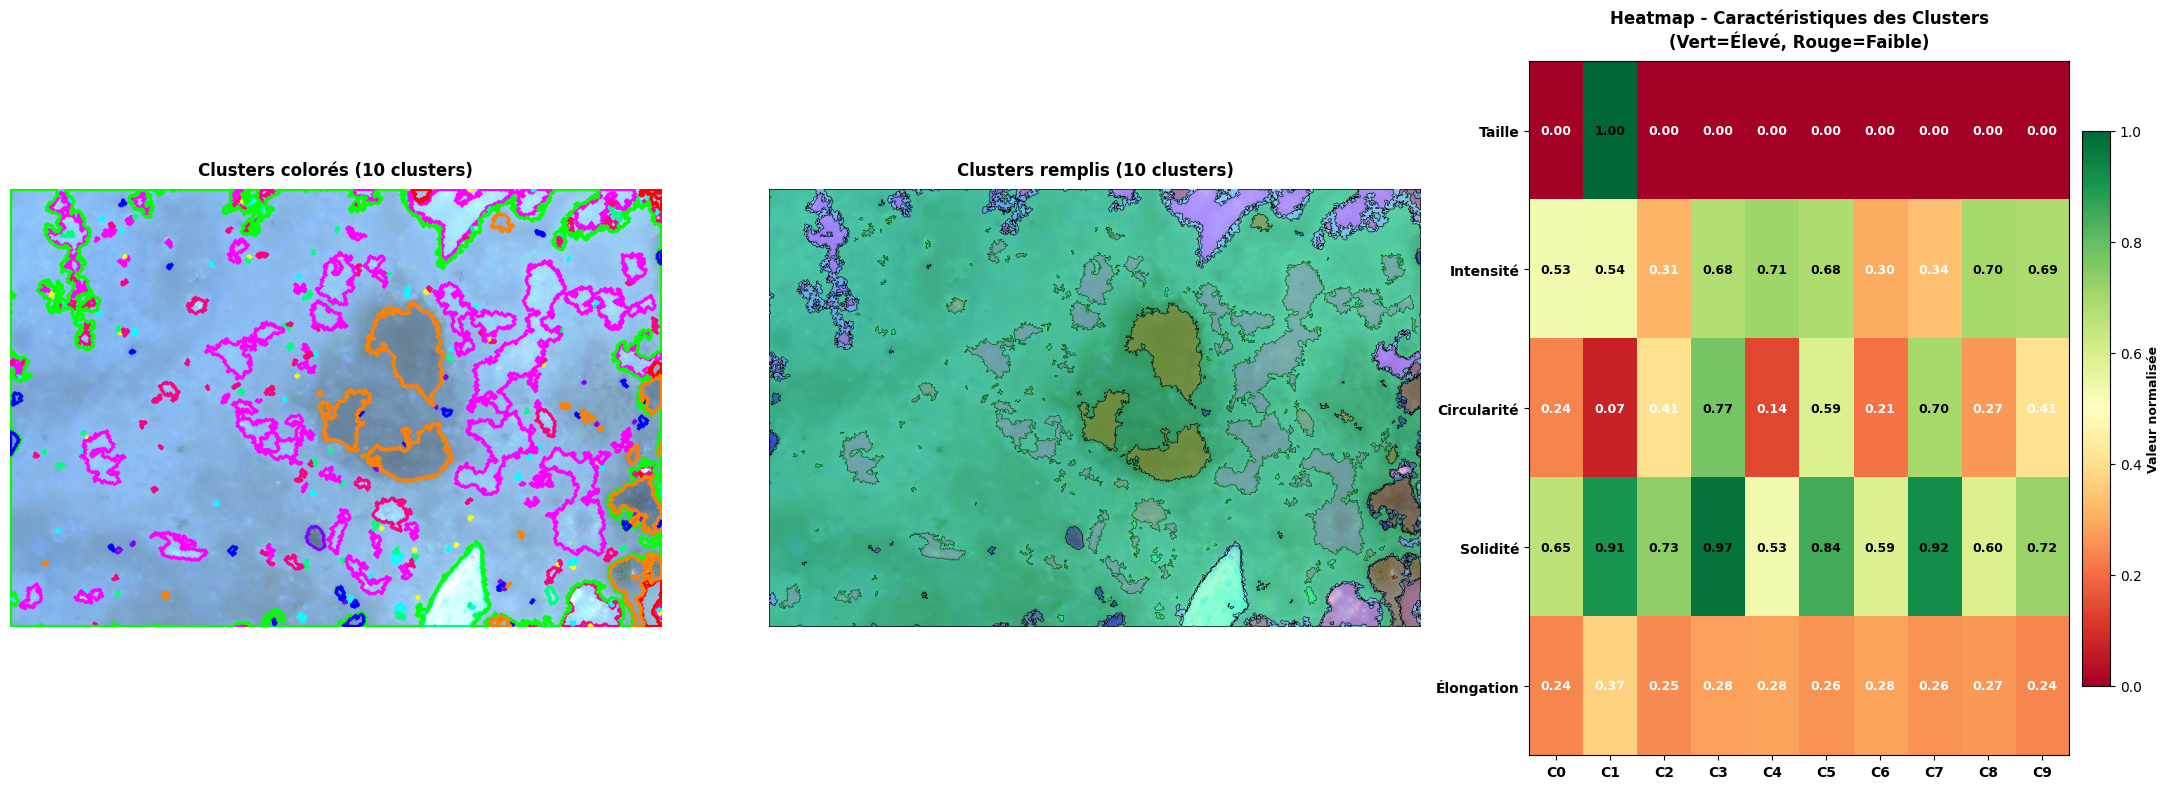


📊 LÉGENDE DES CLUSTERS:

  Cluster 0:
    Couleur RGB: (255, 0, 0)
    Nombre de particules: 5 (1.4%)
    Aire moyenne: 446.2 px²
    Intensité moyenne: 135.3/255

  Cluster 1:
    Couleur RGB: (0, 255, 0)
    Nombre de particules: 1 (0.3%)
    Aire moyenne: 519978.5 px²
    Intensité moyenne: 137.4/255

  Cluster 2:
    Couleur RGB: (0, 0, 255)
    Nombre de particules: 30 (8.6%)
    Aire moyenne: 47.4 px²
    Intensité moyenne: 80.0/255

  Cluster 3:
    Couleur RGB: (255, 255, 0)
    Nombre de particules: 23 (6.6%)
    Aire moyenne: 6.8 px²
    Intensité moyenne: 172.4/255

  Cluster 4:
    Couleur RGB: (255, 0, 255)
    Nombre de particules: 68 (19.5%)
    Aire moyenne: 874.3 px²
    Intensité moyenne: 180.4/255

  Cluster 5:
    Couleur RGB: (0, 255, 255)
    Nombre de particules: 52 (14.9%)
    Aire moyenne: 15.9 px²
    Intensité moyenne: 173.6/255

  Cluster 6:
    Couleur RGB: (255, 128, 0)
    Nombre de particules: 25 (7.2%)
    Aire moyenne: 1014.1 px²
    Intensité moyenne

In [73]:
# ✅ Visualisation des clusters sur l'image avec meilleur contraste et couleurs

# Créer DataFrame consolidé
all_features = features_type1 + features_type2 + features_type3
df_particles = pd.DataFrame(all_features)

# ✅ Conserver l'ordre des contours (aligné avec df_particles)
all_contours = contours_type1 + contours_type2 + contours_type3

print(f"\n✓ Total particules détectées: {len(df_particles)}")
print(f"  Colonnes disponibles: {list(df_particles.columns)}")

# Ajouter la colonne Cluster si elle n'existe pas
if 'Cluster' not in df_particles.columns and 'Cluster_Combined' not in df_particles.columns:
    # Effectuer le clustering KMeans avec les colonnes disponibles
    clustering_features = df_particles[['Area_px2', 'Circularity', 'MeanIntensity']].values
    
    from sklearn.preprocessing import StandardScaler
    scaler_viz = StandardScaler()
    clustering_features_scaled = scaler_viz.fit_transform(clustering_features)
    
    n_clusters_viz = min(10, max(5, len(df_particles) // 20))
    kmeans_viz = KMeans(n_clusters=n_clusters_viz, random_state=42, n_init=50)
    df_particles['Cluster'] = kmeans_viz.fit_predict(clustering_features_scaled)
elif 'Cluster_Combined' in df_particles.columns:
    df_particles['Cluster'] = df_particles['Cluster_Combined']

print("\n🖼️ Affichage des clusters sur l'image avec couleurs optimisées...")

# Palettes de couleurs vibrantes et distinctes pour chaque cluster
vibrante_colors = [
    (255, 0, 0),      # Rouge vif
    (0, 255, 0),      # Vert vif
    (0, 0, 255),      # Bleu vif
    (255, 255, 0),    # Jaune vif
    (255, 0, 255),    # Magenta
    (0, 255, 255),    # Cyan
    (255, 128, 0),    # Orange
    (128, 0, 255),    # Violet
    (255, 0, 128),    # Rose
    (0, 255, 128),    # Vert clair
]

n_clusters = df_particles["Cluster"].nunique()

# Créer trois visualisations : contours, remplissage, et heatmap
fig, axes = plt.subplots(1, 3, figsize=(22, 8))

# ===== Première image : contours colorés avec fond original =====
overlay_contours = img_rgb.copy().astype(float)
overlay_contours = overlay_contours * 0.85 + 50  # Légère atténuation du fond

for idx, cnt in enumerate(all_contours):
    if idx >= len(df_particles):
        continue
    cluster_id = int(df_particles.iloc[idx]["Cluster"])
    color = vibrante_colors[cluster_id % len(vibrante_colors)]
    cv2.drawContours(overlay_contours, [cnt], -1, color, 3)  # Épaisseur: 3

overlay_contours = np.clip(overlay_contours, 0, 255).astype(np.uint8)
axes[0].imshow(overlay_contours)
axes[0].set_title(f"Clusters colorés ({n_clusters} clusters)", 
                   fontsize=12, fontweight='bold', pad=10)
axes[0].axis('off')

# ===== Deuxième image : remplissage semi-transparent par cluster =====
overlay_filled = img_rgb.copy().astype(float)

for idx, cnt in enumerate(all_contours):
    if idx >= len(df_particles):
        continue
    cluster_id = int(df_particles.iloc[idx]["Cluster"])
    color = vibrante_colors[cluster_id % len(vibrante_colors)]
    
    # Remplir le contour avec transparence
    mask_particle = np.zeros(overlay_filled.shape[:2], dtype=np.uint8)
    cv2.drawContours(mask_particle, [cnt], -1, 255, -1)
    
    # Appliquer la couleur avec 30% d'opacité
    for c in range(3):
        overlay_filled[mask_particle > 0, c] = (
            overlay_filled[mask_particle > 0, c] * 0.7 + color[c] * 0.3
        )
    
    # Ajouter un contour noir pour délimitation
    cv2.drawContours(overlay_filled, [cnt], -1, (0, 0, 0), 1)

overlay_filled = np.clip(overlay_filled, 0, 255).astype(np.uint8)
axes[1].imshow(overlay_filled)
axes[1].set_title(f"Clusters remplis ({n_clusters} clusters)", 
                   fontsize=12, fontweight='bold', pad=10)
axes[1].axis('off')

# ===== Troisième image : HEATMAP des caractéristiques des clusters =====
import seaborn as sns

# Créer une heatmap montrant les caractéristiques normalisées de chaque cluster
heatmap_data = []
cluster_ids = sorted(df_particles['Cluster'].unique())

for cluster_id in cluster_ids:
    cluster_data = df_particles[df_particles['Cluster'] == cluster_id]
    
    # Extraire les statistiques (normalisées)
    norm_size = cluster_data['Area_px2'].mean() / df_particles['Area_px2'].max()
    norm_intensity = cluster_data['MeanIntensity'].mean() / 255.0
    norm_circularity = cluster_data['Circularity'].mean()
    norm_solidity = cluster_data['Solidity'].mean()
    norm_aspect = min(cluster_data['AspectRatio'].mean() / 4.0, 1.0)  # Normalisé à max 4
    
    heatmap_data.append([norm_size, norm_intensity, norm_circularity, norm_solidity, norm_aspect])

# Convertir en array numpy
heatmap_array = np.array(heatmap_data).T

# Créer la heatmap
heatmap_ax = axes[2]
im = heatmap_ax.imshow(heatmap_array, cmap='RdYlGn', aspect='auto', vmin=0, vmax=1)

# Configurer les labels
heatmap_ax.set_xticks(range(len(cluster_ids)))
heatmap_ax.set_xticklabels([f'C{cid}' for cid in cluster_ids], fontsize=10, fontweight='bold')
heatmap_ax.set_yticks(range(5))
heatmap_ax.set_yticklabels(['Taille', 'Intensité', 'Circularité', 'Solidité', 'Élongation'], 
                             fontsize=10, fontweight='bold')

# Ajouter les valeurs dans les cellules
for i in range(len(heatmap_array)):
    for j in range(len(cluster_ids)):
        value = heatmap_array[i, j]
        color = 'white' if value < 0.5 else 'black'
        heatmap_ax.text(j, i, f'{value:.2f}', ha='center', va='center', 
                       color=color, fontsize=9, fontweight='bold')

heatmap_ax.set_title(f'Heatmap - Caractéristiques des Clusters\n(Vert=Élevé, Rouge=Faible)', 
                      fontsize=12, fontweight='bold', pad=10)

# Ajouter une barre de couleur
cbar = plt.colorbar(im, ax=heatmap_ax, orientation='vertical', pad=0.02, shrink=0.8)
cbar.set_label('Valeur normalisée', fontsize=9, fontweight='bold')

plt.tight_layout()
plt.savefig('clusters_visualization_enhanced.png', dpi=300, bbox_inches='tight')
plt.show()

# ===== Créer une légende des clusters =====
print("\n📊 LÉGENDE DES CLUSTERS:")
print("="*70)
for cluster_id in sorted(df_particles['Cluster'].unique()):
    count = len(df_particles[df_particles['Cluster'] == cluster_id])
    percentage = 100 * count / len(df_particles)
    avg_area = df_particles[df_particles['Cluster'] == cluster_id]['Area_px2'].mean()
    avg_intensity = df_particles[df_particles['Cluster'] == cluster_id]['MeanIntensity'].mean()
    color_idx = cluster_id % len(vibrante_colors)
    color_rgb = vibrante_colors[color_idx]
    
    print(f"\n  Cluster {cluster_id}:")
    print(f"    Couleur RGB: {color_rgb}")
    print(f"    Nombre de particules: {count} ({percentage:.1f}%)")
    print(f"    Aire moyenne: {avg_area:.1f} px²")
    print(f"    Intensité moyenne: {avg_intensity:.1f}/255")

print(f"\n✓ Visualisation sauvegardée: clusters_visualization_enhanced.png (avec HEATMAP)")


📋 TABLEAU DÉTAILLÉ DES CLUSTERS - ANALYSE COMPLÈTE

✓ Tableau des clusters:
Cluster                              Label          Morphologie  Nombre     % Aire (px²) Intensité Circularité Solidité Aspect
     C0     Claires_Grandes_Intermédiaires    Fractale_rugueuse       5  1.4%        446       135        0.24     0.65    1.0
     C1          Claires_Petites_Compactes Cristalline_facettee       1  0.3%     519978       137        0.07     0.91    1.5
     C2     Sombres_Grandes_Intermédiaires    Fractale_rugueuse      30  8.6%         47        80        0.41     0.73    1.0
     C3 Grises_Très_Grandes_Intermédiaires Cristalline_facettee      23  6.6%          7       172        0.77     0.97    1.1
     C4      Claires_Moyennes_Irrégulières    Fractale_rugueuse      68 19.5%        874       180        0.14     0.53    1.1
     C5          Sombres_Petites_Compactes          Irreguliere      52 14.9%         16       174        0.59     0.84    1.0
     C6    Claires_Moyennes_Interm

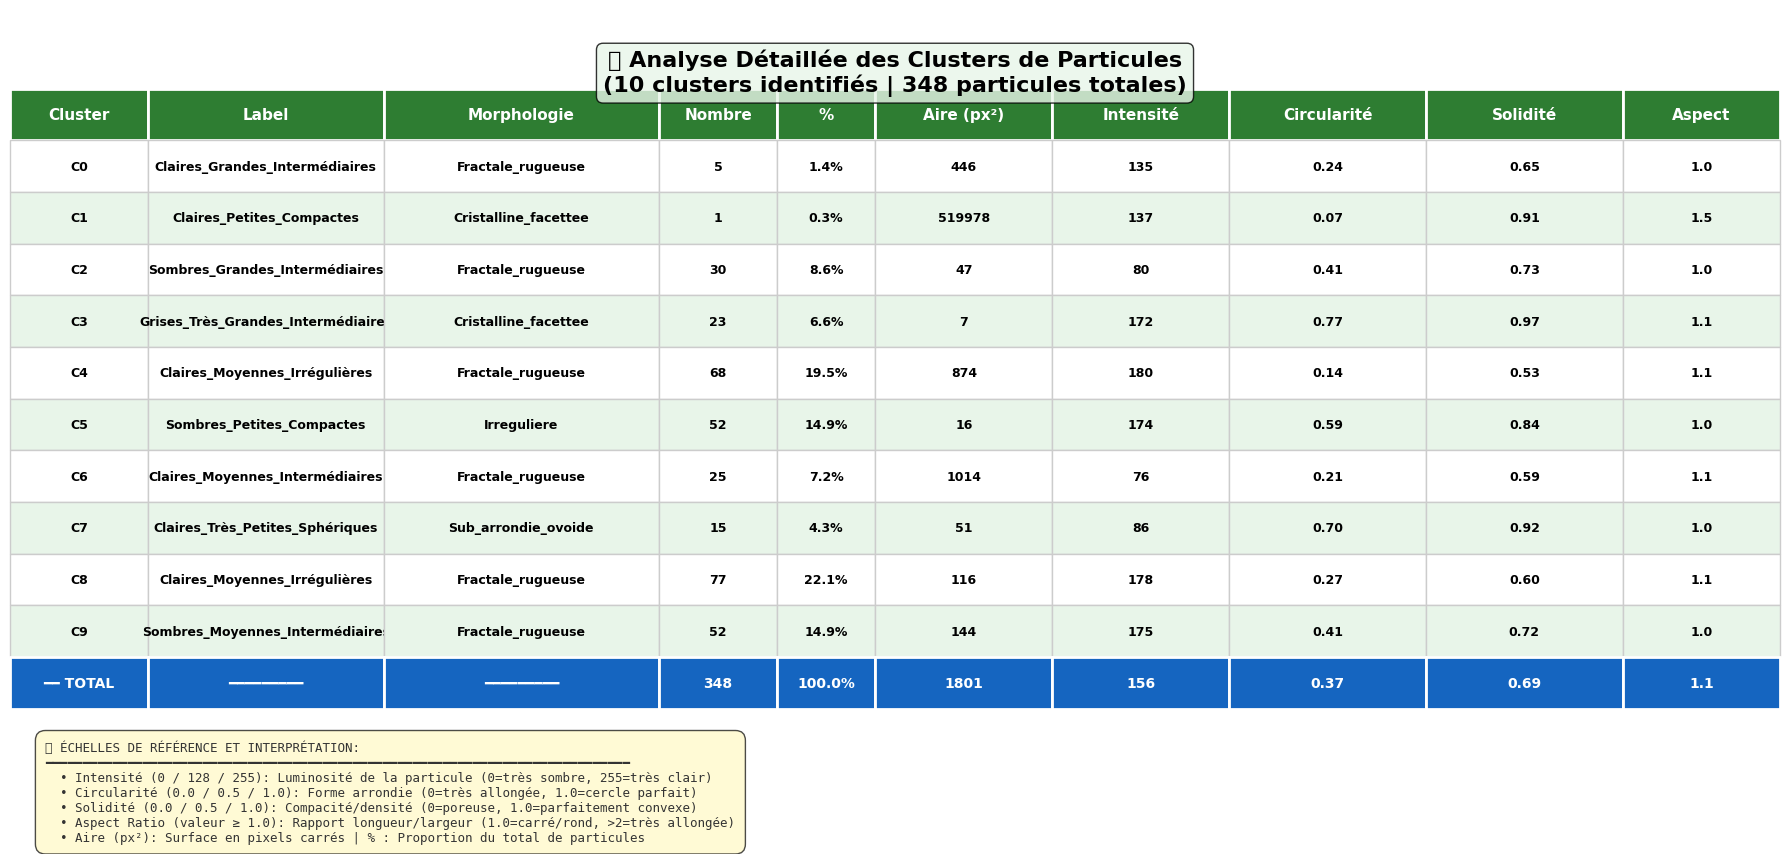


✓ Tableau sauvegardé: cluster_analysis_table.png (10 clusters + TOTAL)

📏 Interprétation des colonnes:
   Intensité: 0 (très sombre) / 128 (gris moyen) / 255 (très clair)
   Circularité: 0.0 (très allongée) / 0.5 (intermédiaire) / 1.0 (cercle parfait)
   Solidité: 0.0 (poreuse) / 0.5 (semi-solide) / 1.0 (parfaitement convexe)
   Aspect: 1.0 (carré/rond) / 2.0 (rectangulaire) / 3.0+ (très allongée)


In [74]:
# Créer un tableau détaillé des clusters avec label, morphologie, échelles et TOTAUX
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

print("\n📋 TABLEAU DÉTAILLÉ DES CLUSTERS - ANALYSE COMPLÈTE")
print("="*80)

# Créer un dataframe avec les statistiques par cluster
cluster_stats = []

for cluster_id in sorted(df_particles['Cluster'].unique()):
    cluster_data = df_particles[df_particles['Cluster'] == cluster_id]
    
    count = len(cluster_data)
    percentage = (count / len(df_particles) * 100)
    
    # Récupérer label et morphologie
    label = cluster_labels.get(cluster_id, 'N/A') if 'cluster_labels' in dir() else 'N/A'
    morphology = cluster_morphologies.get(cluster_id, 'N/A') if 'cluster_morphologies' in dir() else 'N/A'
    
    # Statistiques morphologiques - utiliser les colonnes disponibles
    avg_size = cluster_data['Area_px2'].mean()
    avg_intensity = cluster_data['MeanIntensity'].mean()
    avg_circularity = cluster_data['Circularity'].mean()
    avg_solidity = cluster_data['Solidity'].mean()
    avg_aspect_ratio = cluster_data['AspectRatio'].mean()
    
    cluster_stats.append({
        'Cluster': f'C{cluster_id}',
        'Label': label,
        'Morphologie': morphology,
        'Nombre': count,
        '%': f'{percentage:.1f}%',
        'Aire (px²)': f'{avg_size:.0f}',
        'Intensité': f'{avg_intensity:.0f}',
        'Circularité': f'{avg_circularity:.2f}',
        'Solidité': f'{avg_solidity:.2f}',
        'Aspect': f'{avg_aspect_ratio:.1f}'
    })

df_table = pd.DataFrame(cluster_stats)

print("\n✓ Tableau des clusters:")
print(df_table.to_string(index=False))

# Calculer les totaux et moyennes
total_count = int(df_table['Nombre'].sum())
total_percentage = 100.0

# Moyennes pondérées pour les métriques numériques
total_aire = df_particles['Area_px2'].sum()
avg_aire = df_particles['Area_px2'].mean()
avg_intensity_all = df_particles['MeanIntensity'].mean()
avg_circularity_all = df_particles['Circularity'].mean()
avg_solidity_all = df_particles['Solidity'].mean()
avg_aspect_all = df_particles['AspectRatio'].mean()

# Créer la ligne de totaux
total_row = {
    'Cluster': '━━ TOTAL',
    'Label': '━━━━━━━━━',
    'Morphologie': '━━━━━━━━━',
    'Nombre': f'{total_count}',
    '%': f'{total_percentage:.1f}%',
    'Aire (px²)': f'{avg_aire:.0f}',
    'Intensité': f'{avg_intensity_all:.0f}',
    'Circularité': f'{avg_circularity_all:.2f}',
    'Solidité': f'{avg_solidity_all:.2f}',
    'Aspect': f'{avg_aspect_all:.1f}'
}

# Calculate number of rows BEFORE using it
n_rows = len(df_table)

print(f"\n{'='*80}")
print(f"📊 RÉSUMÉ GLOBAL:")
print(f"   Nombre total de particules: {total_count}")
print(f"   Nombre de clusters: {n_rows}")
print(f"   Aire totale: {total_aire:.0f} px²")
print(f"   Aire moyenne par particule: {avg_aire:.1f} px²")
print(f"   Intensité moyenne globale: {avg_intensity_all:.1f}/255")
print(f"   Circularité moyenne globale: {avg_circularity_all:.2f}")
print(f"   Solidité moyenne globale: {avg_solidity_all:.2f}")
print(f"   Aspect ratio moyen global: {avg_aspect_all:.1f}")
print(f"{'='*80}")

# Créer une visualisation du tableau avec totaux
fig_height = max(7, (n_rows + 1) * 0.5) + 2.0  # +1 pour la ligne de totaux, +1 pour titre/légende
fig, ax = plt.subplots(figsize=(18, fig_height))
ax.axis('tight')
ax.axis('off')

# Titre amélioré avec informations contextuelles (AVANT le tableau)
title_text = f'📊 Analyse Détaillée des Clusters de Particules\n({n_rows} clusters identifiés | {len(df_particles)} particules totales)'
ax.text(0.5, 0.95, title_text, ha='center', va='top', fontsize=16, weight='bold', 
        transform=ax.transAxes, bbox=dict(boxstyle='round', facecolor='#E8F5E9', alpha=0.8))

# Créer le tableau avec la ligne de totaux
table_data = [df_table.columns.tolist()] + df_table.values.tolist() + [list(total_row.values())]

# Ajuster les largeurs de colonnes pour les 10 colonnes
col_widths = [0.07, 0.12, 0.14, 0.06, 0.05, 0.09, 0.09, 0.10, 0.10, 0.08]

table = ax.table(
    cellText=table_data,
    cellLoc='center',
    loc='center',
    colWidths=col_widths,
    bbox=[0, 0.12, 1, 0.78]  # Position du tableau plus bas pour la légende
)

# Formater le tableau
table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 2.8)

# Colorer l'en-tête avec une couleur plus attrayante
header_color = '#2E7D32'  # Vert foncé
for i in range(len(df_table.columns)):
    cell = table[(0, i)]
    cell.set_facecolor(header_color)
    cell.set_text_props(weight='bold', color='white', fontsize=11)
    cell.set_edgecolor('white')
    cell.set_linewidth(2)

# Colorer les lignes alternées et la ligne de totaux
colors_alt = ['#E8F5E9', '#FFFFFF']  # Vert très clair et blanc
for i in range(1, len(table_data) - 1):
    for j in range(len(df_table.columns)):
        cell = table[(i, j)]
        cell.set_facecolor(colors_alt[i % 2])
        cell.set_text_props(weight='bold', fontsize=9)
        cell.set_edgecolor('#CCCCCC')
        cell.set_linewidth(1)

# Colorer la ligne de totaux en bleu foncé
total_color = '#1565C0'  # Bleu foncé
for i in range(len(df_table.columns)):
    cell = table[(len(table_data) - 1, i)]
    cell.set_facecolor(total_color)
    cell.set_text_props(weight='bold', color='white', fontsize=10)
    cell.set_edgecolor('white')
    cell.set_linewidth(2)

# Ajouter une légende avec les échelles de référence
legend_text = (
    "📏 ÉCHELLES DE RÉFÉRENCE ET INTERPRÉTATION:\n"
    "━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━\n"
    "  • Intensité (0 / 128 / 255): Luminosité de la particule (0=très sombre, 255=très clair)\n"
    "  • Circularité (0.0 / 0.5 / 1.0): Forme arrondie (0=très allongée, 1.0=cercle parfait)\n"
    "  • Solidité (0.0 / 0.5 / 1.0): Compacité/densité (0=poreuse, 1.0=parfaitement convexe)\n"
    "  • Aspect Ratio (valeur ≥ 1.0): Rapport longueur/largeur (1.0=carré/rond, >2=très allongée)\n"
    "  • Aire (px²): Surface en pixels carrés | % : Proportion du total de particules"
)

ax.text(0.02, 0.08, legend_text, ha='left', va='top', fontsize=9, 
        family='monospace', transform=ax.transAxes,
        bbox=dict(boxstyle='round', facecolor='#FFF9C4', alpha=0.7, pad=0.8),
        color='#333333')

plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.savefig('cluster_analysis_table.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print(f"\n{'='*80}")
print(f"✓ Tableau sauvegardé: cluster_analysis_table.png ({n_rows} clusters + TOTAL)")
print(f"{'='*80}")
print(f"\n📏 Interprétation des colonnes:")
print(f"   Intensité: 0 (très sombre) / 128 (gris moyen) / 255 (très clair)")
print(f"   Circularité: 0.0 (très allongée) / 0.5 (intermédiaire) / 1.0 (cercle parfait)")
print(f"   Solidité: 0.0 (poreuse) / 0.5 (semi-solide) / 1.0 (parfaitement convexe)")
print(f"   Aspect: 1.0 (carré/rond) / 2.0 (rectangulaire) / 3.0+ (très allongée)")
print(f"{'='*80}")

## 6️⃣.2 Pivots et Heatmaps Paramétriques

In [75]:
print("\n🔥 GÉNÉRATION DES PIVOTS ET HEATMAPS PARAMÉTRIQUES")
print("="*70)

if 'Cluster_Combined' in df_particles.columns and 'Particle_Type_Combined' in df_particles.columns:
    # Pivots: Cluster × Type
    pivot_size = pd.pivot_table(
        df_particles,
        values='Size_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_shape = pd.pivot_table(
        df_particles,
        values='Shape_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_intensity = pd.pivot_table(
        df_particles,
        values='Intensity_Score',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='mean'
    )
    
    pivot_count = pd.pivot_table(
        df_particles,
        values='Area_px2',
        index='Cluster_Combined',
        columns='Particle_Type_Combined',
        aggfunc='count'
    ).fillna(0).astype(int)
    
    # Visualisation des heatmaps
    fig, axes = plt.subplots(2, 2, figsize=(20, 14))
    
    # Heatmap 1: Taille moyenne
    ax = axes[0, 0]
    im1 = ax.imshow(pivot_size.values, cmap='YlOrRd', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_size.columns)))
    ax.set_xticklabels(pivot_size.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_size.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_size.index])
    ax.set_title('Taille Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im1, ax=ax, label='Taille (px²)')
    
    # Heatmap 2: Forme moyenne
    ax = axes[0, 1]
    im2 = ax.imshow(pivot_shape.values, cmap='Greens', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_shape.columns)))
    ax.set_xticklabels(pivot_shape.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_shape.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_shape.index])
    ax.set_title('Forme Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im2, ax=ax, label='Score Forme')
    
    # Heatmap 3: Intensité moyenne
    ax = axes[1, 0]
    im3 = ax.imshow(pivot_intensity.values, cmap='Blues', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_intensity.columns)))
    ax.set_xticklabels(pivot_intensity.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_intensity.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_intensity.index])
    ax.set_title('Intensité Moyenne par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Type de Particule', fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im3, ax=ax, label='Intensité')
    
    # Heatmap 4: Nombre de particules
    ax = axes[1, 1]
    im4 = ax.imshow(pivot_count.values, cmap='Purples', aspect='auto', interpolation='nearest')
    ax.set_xticks(range(len(pivot_count.columns)))
    ax.set_xticklabels(pivot_count.columns, rotation=45, ha='right', fontsize=8)
    ax.set_yticks(range(len(pivot_count.index)))
    ax.set_yticklabels([f'C{i}' for i in pivot_count.index])
    ax.set_title('Nombre de Particules par Cluster × Type', fontsize=12, fontweight='bold')
    ax.set_xlabel('Type de Particule', fontweight='bold')
    ax.set_ylabel('Cluster ID', fontweight='bold')
    plt.colorbar(im4, ax=ax, label='Nombre de particules')
    
    plt.tight_layout()
    plt.show()
    
    print("\n✓ Heatmaps paramétriques générées")
    
    # Sauvegarder les pivots
    pivot_size.to_csv("pivot_taille_cluster_type.csv")
    pivot_shape.to_csv("pivot_forme_cluster_type.csv")
    pivot_intensity.to_csv("pivot_intensite_cluster_type.csv")
    pivot_count.to_csv("pivot_count_cluster_type.csv")
    print("✓ Pivots sauvegardés: pivot_*.csv")

print("\n✓ Analyses pivot complètes")


🔥 GÉNÉRATION DES PIVOTS ET HEATMAPS PARAMÉTRIQUES

✓ Analyses pivot complètes


## 7️⃣ Analyse PCA et Réduction Dimensionnelle

In [76]:
print("\n📐 ANALYSE PCA 3D - RÉDUCTION DIMENSIONNELLE")
print("="*70)

# Préparer les données pour PCA - utiliser les colonnes réellement disponibles
# Vérifier les colonnes disponibles
print(f"\n✓ Colonnes disponibles dans df_particles:")
print(f"  {list(df_particles.columns)}")

# Utiliser les colonnes qui existent toujours
available_features = []
all_features = ['Area_px2', 'Perimeter_px', 'Circularity', 'AspectRatio', 'Solidity', 'MeanIntensity']

for feat in all_features:
    if feat in df_particles.columns:
        available_features.append(feat)

print(f"\n✓ Features sélectionnées pour PCA: {available_features}")

X_pca = df_particles[available_features].values

scaler_pca = StandardScaler()
X_pca_scaled = scaler_pca.fit_transform(X_pca)

pca = PCA(n_components=3)
X_pca_3d = pca.fit_transform(X_pca_scaled)

df_particles['PCA_1'] = X_pca_3d[:, 0]
df_particles['PCA_2'] = X_pca_3d[:, 1]
df_particles['PCA_3'] = X_pca_3d[:, 2]

# Afficher les résultats
print(f"\n📊 Variance expliquée par composante:")
for i, var in enumerate(pca.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var*100:.2f}%")

print(f"\n📊 Variance cumulée:")
cum_var = np.cumsum(pca.explained_variance_ratio_)
for i, var in enumerate(cum_var, 1):
    print(f"  PC1-PC{i}: {var*100:.2f}%")


📐 ANALYSE PCA 3D - RÉDUCTION DIMENSIONNELLE

✓ Colonnes disponibles dans df_particles:
  ['Type', 'Area_px2', 'Perimeter_px', 'Circularity', 'AspectRatio', 'Solidity', 'MeanIntensity', 'Center_X', 'Center_Y', 'Cluster']

✓ Features sélectionnées pour PCA: ['Area_px2', 'Perimeter_px', 'Circularity', 'AspectRatio', 'Solidity', 'MeanIntensity']

📊 Variance expliquée par composante:
  PC1: 34.32%
  PC2: 30.51%
  PC3: 16.64%

📊 Variance cumulée:
  PC1-PC1: 34.32%
  PC1-PC2: 64.83%
  PC1-PC3: 81.47%



✓ Colonnes disponibles pour visualisation PCA:
  ['Type', 'Cluster', 'PCA_1', 'PCA_2', 'PCA_3']


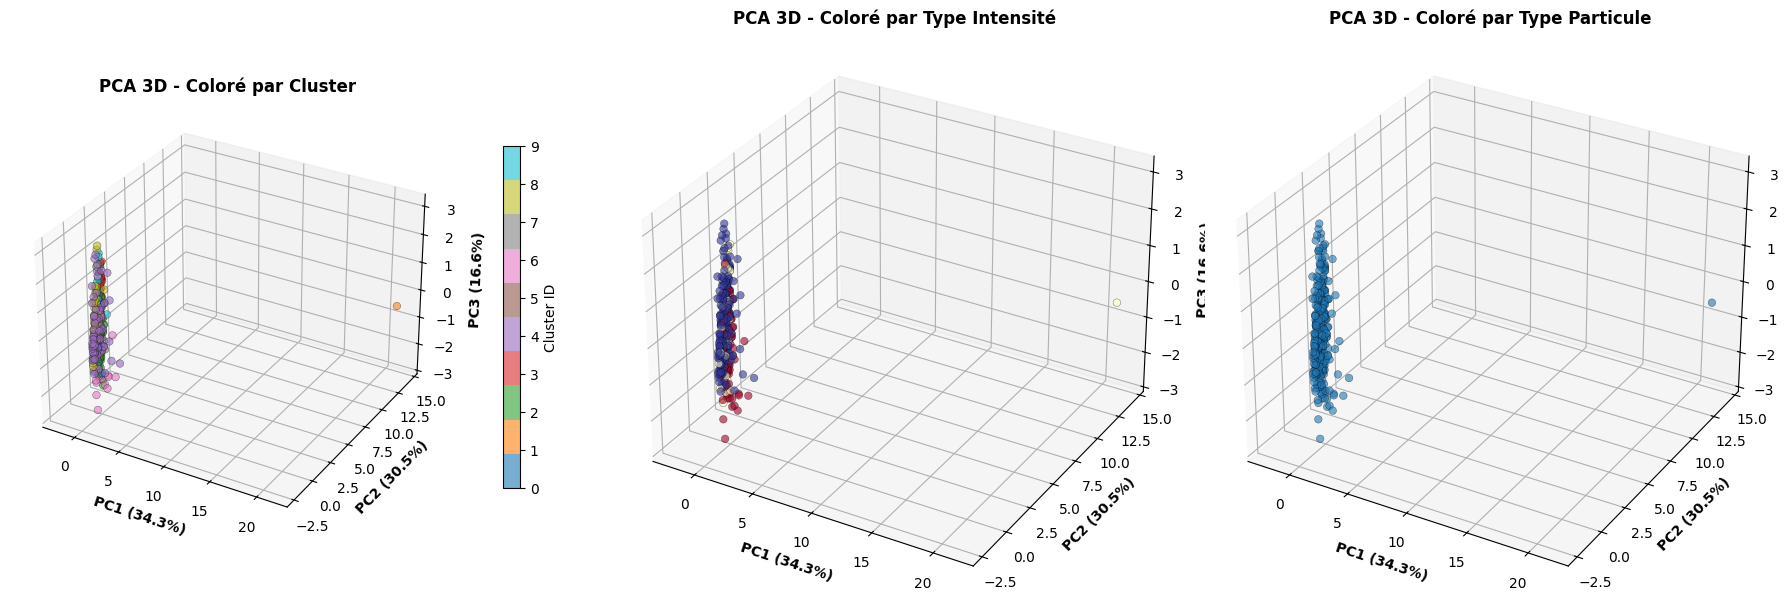


✓ Visualisation PCA 3D générée


In [77]:
# Visualisation 3D PCA
fig = plt.figure(figsize=(18, 6))

# Vérifier les colonnes disponibles
print("\n✓ Colonnes disponibles pour visualisation PCA:")
print(f"  {[col for col in df_particles.columns if 'PCA' in col or 'Cluster' in col or 'Type' in col or 'Particle' in col]}")

# Vue 1: PCA coloré par Cluster (utiliser la colonne appropriée)
ax1 = fig.add_subplot(131, projection='3d')
if 'Cluster_Combined' in df_particles.columns:
    cluster_col = 'Cluster_Combined'
elif 'Cluster_3D' in df_particles.columns:
    cluster_col = 'Cluster_3D'
elif 'Cluster' in df_particles.columns:
    cluster_col = 'Cluster'
else:
    # Si aucun clustering n'existe, créer un clustering temporaire pour la visualisation
    print("\n⚠️ Aucune colonne de clustering trouvée, création d'un clustering K-means pour la visualisation...")
    from sklearn.cluster import KMeans
    temp_kmeans = KMeans(n_clusters=min(5, len(df_particles)), random_state=42)
    df_particles['Cluster_Temp'] = temp_kmeans.fit_predict(X_pca_scaled)
    cluster_col = 'Cluster_Temp'

scatter1 = ax1.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=df_particles[cluster_col], 
                       cmap='tab10', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax1.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax1.set_title('PCA 3D - Coloré par Cluster', fontsize=12, fontweight='bold')
plt.colorbar(scatter1, ax=ax1, label='Cluster ID', shrink=0.6, pad=0.1)

# Vue 2: PCA coloré par Type d'intensité
ax2 = fig.add_subplot(132, projection='3d')
if 'Type' in df_particles.columns:
    type_colors = {'Type_1_Blanc': 0, 'Type_2_Gris': 1, 'Type_3_Noir': 2}
    color_map = df_particles['Type'].map(type_colors).fillna(0)
else:
    # Si la colonne Type n'existe pas, utiliser une valeur par défaut
    color_map = np.zeros(len(df_particles))

scatter2 = ax2.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=color_map, 
                       cmap='RdYlBu_r', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax2.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax2.set_title('PCA 3D - Coloré par Type Intensité', fontsize=12, fontweight='bold')

# Vue 3: PCA coloré par Particle_Type_Combined
ax3 = fig.add_subplot(133, projection='3d')
if 'Particle_Type_Combined' in df_particles.columns:
    unique_ptypes = df_particles['Particle_Type_Combined'].unique()
    ptype_to_num = {t: i for i, t in enumerate(unique_ptypes)}
    color_map_ptype = df_particles['Particle_Type_Combined'].map(ptype_to_num)
else:
    # Si la colonne n'existe pas, utiliser une valeur par défaut
    color_map_ptype = np.zeros(len(df_particles))

scatter3 = ax3.scatter(df_particles['PCA_1'], 
                       df_particles['PCA_2'],
                       df_particles['PCA_3'],
                       c=color_map_ptype, 
                       cmap='tab20', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
ax3.set_xlabel(f'PC1 ({pca.explained_variance_ratio_[0]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_ylabel(f'PC2 ({pca.explained_variance_ratio_[1]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_zlabel(f'PC3 ({pca.explained_variance_ratio_[2]*100:.1f}%)', fontsize=10, fontweight='bold')
ax3.set_title('PCA 3D - Coloré par Type Particule', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✓ Visualisation PCA 3D générée")

## 8️⃣ Identification de la Zone Équilibrée Représentative

In [78]:
print("\n📍 IDENTIFICATION DE LA ZONE ÉQUILIBRÉE REPRÉSENTATIVE")
print("="*70)

# Créer les informations de la zone équilibrée à partir des données actuelles
zone_info = {
    'Total_Particles': len(df_particles),
    'Total_Area_px2': df_particles['Area_px2'].sum(),
    'Avg_Area_px2': df_particles['Area_px2'].mean(),
    'Avg_Intensity': df_particles['MeanIntensity'].mean(),
    'Avg_Circularity': df_particles['Circularity'].mean(),
    'Avg_Solidity': df_particles['Solidity'].mean(),
    'Avg_AspectRatio': df_particles['AspectRatio'].mean(),
}

# Ajouter les décomptes par cluster s'ils existent
if 'Cluster' in df_particles.columns:
    for cluster_id in sorted(df_particles['Cluster'].unique()):
        count = len(df_particles[df_particles['Cluster'] == cluster_id])
        zone_info[f'Cluster_{cluster_id}_Count'] = count
elif 'Cluster_Combined' in df_particles.columns:
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        count = len(df_particles[df_particles['Cluster_Combined'] == cluster_id])
        zone_info[f'Cluster_{cluster_id}_Count'] = count
elif 'Cluster_3D' in df_particles.columns:
    for cluster_id in sorted(df_particles['Cluster_3D'].unique()):
        count = len(df_particles[df_particles['Cluster_3D'] == cluster_id])
        zone_info[f'Cluster_{cluster_id}_Count'] = count

# Ajouter les décomptes par type si disponibles
if 'Type' in df_particles.columns:
    for type_name in sorted(df_particles['Type'].unique()):
        count = len(df_particles[df_particles['Type'] == type_name])
        zone_info[f'Type_{type_name}_Count'] = count

if 'Particle_Type_Combined' in df_particles.columns:
    for ptype_name in sorted(df_particles['Particle_Type_Combined'].unique()):
        count = len(df_particles[df_particles['Particle_Type_Combined'] == ptype_name])
        zone_info[f'ParticleType_{ptype_name}_Count'] = count

# Sauvegarder les informations
zone_info_df = pd.DataFrame([zone_info])
zone_info_df.to_csv("zone_equilibree_info.csv", index=False)
print("\n✓ Informations de la zone équilibrée sauvegardées: zone_equilibree_info.csv")
print(f"\n📊 Résumé:")
print(f"   Total de particules: {zone_info['Total_Particles']}")
print(f"   Aire totale: {zone_info['Total_Area_px2']:.0f} px²")
print(f"   Aire moyenne: {zone_info['Avg_Area_px2']:.1f} px²")
print(f"   Intensité moyenne: {zone_info['Avg_Intensity']:.1f}/255")
print(f"   Circularité moyenne: {zone_info['Avg_Circularity']:.3f}")

# IMPORTANT: Créer la classification combinée AVANT les visualisations qui l'utilisent
print("\n🏷️ Création de la classification combinée Particle_Type_Combined...")

def classify_particle_combined(row):
    """Classification combinée: Intensity × Size × Shape"""
    intensity = row['Intensity_Score'] if 'Intensity_Score' in row else row['MeanIntensity']
    size = row['Size_Score'] if 'Size_Score' in row else row['Area_px2']
    shape = row['Shape_Score'] if 'Shape_Score' in row else row['Circularity']
    
    # Seuils
    intensity_low, intensity_high = 85, 170
    size_threshold = 150
    shape_threshold = 0.7
    
    # Déterminer Intensité
    if intensity < intensity_low:
        intensity_label = "Noir"
    elif intensity < intensity_high:
        intensity_label = "Gris"
    else:
        intensity_label = "Blanc"
    
    # Déterminer Taille
    size_label = "Petit" if size < size_threshold else "Grand"
    
    # Déterminer Forme
    shape_label = "Rond" if shape > shape_threshold else "Anguleux"
    
    return f"{intensity_label}_{size_label}_{shape_label}"

if 'Particle_Type_Combined' not in df_particles.columns:
    df_particles['Particle_Type_Combined'] = df_particles.apply(classify_particle_combined, axis=1)
    print(f"✓ Classification créée avec {df_particles['Particle_Type_Combined'].nunique()} types uniques")
else:
    print(f"✓ Classification Particle_Type_Combined déjà présente avec {df_particles['Particle_Type_Combined'].nunique()} types uniques")


📍 IDENTIFICATION DE LA ZONE ÉQUILIBRÉE REPRÉSENTATIVE

✓ Informations de la zone équilibrée sauvegardées: zone_equilibree_info.csv

📊 Résumé:
   Total de particules: 348
   Aire totale: 626604 px²
   Aire moyenne: 1800.6 px²
   Intensité moyenne: 156.5/255
   Circularité moyenne: 0.370

🏷️ Création de la classification combinée Particle_Type_Combined...
✓ Classification créée avec 9 types uniques



🎯 IDENTIFICATION D'UNE ZONE REPRÉSENTATIVE ÉQUILIBRÉE

✓ Nombre total de clusters: 10
✓ Nombre total de particules: 348

🔍 Recherche d'une zone équilibrée...
   Taille de fenêtre: 200x200px

✓ Zone trouvée:
   Position: (800, 400)
   Particules: 28
   Clusters présents: 9/10


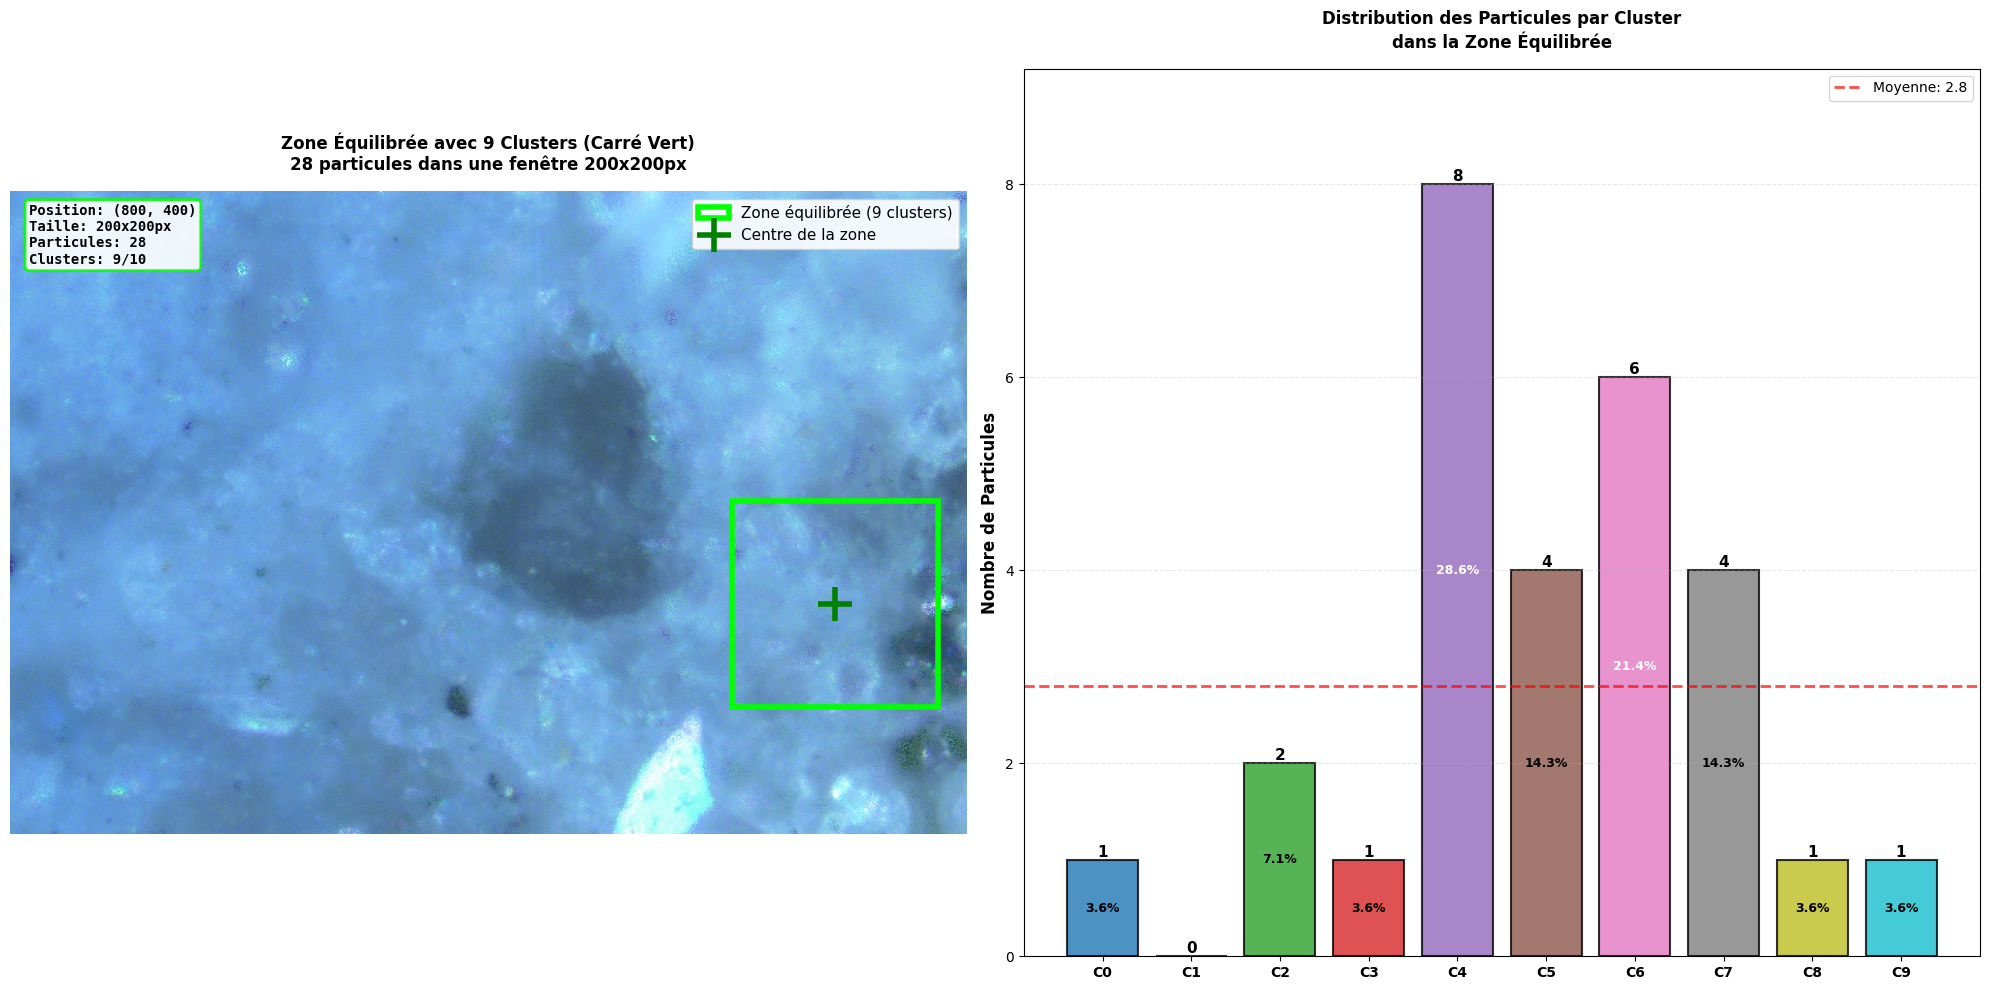


✓ Zone équilibrée visualisée

📊 TABLEAU RÉCAPITULATIF - PARTICULES PAR CLUSTER DANS LA ZONE

Cluster    Quantité     % Zone       % Global     Écart     
--------------------------------------------------------------------------------
Cluster 0  1              3.57%        1.44%       +2.13%
Cluster 1  0              0.00%        0.29%       -0.29%
Cluster 2  2              7.14%        8.62%       -1.48%
Cluster 3  1              3.57%        6.61%       -3.04%
Cluster 4  8             28.57%       19.54%       +9.03%
Cluster 5  4             14.29%       14.94%       -0.66%
Cluster 6  6             21.43%        7.18%      +14.24%
Cluster 7  4             14.29%        4.31%       +9.98%
Cluster 8  1              3.57%       22.13%      -18.56%
Cluster 9  1              3.57%       14.94%      -11.37%
--------------------------------------------------------------------------------
TOTAL      28           100.00%     

✓ Informations du meilleur échantillon sauvegardées: best_represe

In [79]:
print("\n🎯 IDENTIFICATION D'UNE ZONE REPRÉSENTATIVE ÉQUILIBRÉE")
print("="*70)

# Déterminer le nombre total de clusters
if 'Cluster_Combined' in df_particles.columns:
    cluster_col = 'Cluster_Combined'
    total_clusters = df_particles['Cluster_Combined'].nunique()
elif 'Cluster_3D' in df_particles.columns:
    cluster_col = 'Cluster_3D'
    total_clusters = df_particles['Cluster_3D'].nunique()
elif 'Cluster' in df_particles.columns:
    cluster_col = 'Cluster'
    total_clusters = df_particles['Cluster'].nunique()
else:
    print("⚠️ Aucune colonne de clustering trouvée. Utilisation des contours détectés.")
    cluster_col = None
    total_clusters = len(all_contours) if 'all_contours' in dir() else len(df_particles)

print(f"\n✓ Nombre total de clusters: {total_clusters}")
print(f"✓ Nombre total de particules: {len(df_particles)}")

# Calculer les comptes de clusters globaux
global_cluster_counts = {}
if cluster_col:
    for cluster_id in df_particles[cluster_col].unique():
        global_cluster_counts[cluster_id] = len(df_particles[df_particles[cluster_col] == cluster_id])

# Chercher une zone équilibrée représentative
# Utiliser une fenêtre carrée qui contient un bon équilibre de clusters
print("\n🔍 Recherche d'une zone équilibrée...")

# Dimensionner la fenêtre en fonction de la distribution
height, width = img_rgb.shape[:2]
square_size = int(min(height, width) * 0.4)  # 40% de la plus petite dimension
square_size = (square_size // 50) * 50  # Arrondir à 50px

print(f"   Taille de fenêtre: {square_size}x{square_size}px")

# Chercher la meilleure position
best_score_overall = -np.inf
best_window = None
region_cluster_counts = {}

# Diviser l'image en grille
step = square_size // 4
best_results = []

for y in range(0, height - square_size, step):
    for x in range(0, width - square_size, step):
        # Compter les particules dans cette région
        x_min, x_max = x, x + square_size
        y_min, y_max = y, y + square_size
        
        # Trouver les particules dans le rectangle
        mask_region = (df_particles['Center_X'] >= x_min) & (df_particles['Center_X'] < x_max) & \
                      (df_particles['Center_Y'] >= y_min) & (df_particles['Center_Y'] < y_max)
        
        particles_in_region = df_particles[mask_region]
        n_particles = len(particles_in_region)
        
        if n_particles >= 5:  # Minimum de particules pour une région valide
            # Calculer un score basé sur la diversité de clusters
            if cluster_col:
                clusters_present = particles_in_region[cluster_col].nunique()
                score = clusters_present + 0.1 * n_particles  # Préférer diversité + nombre
            else:
                score = n_particles
            
            best_results.append({
                'x': x,
                'y': y,
                'n_particles': n_particles,
                'clusters': particles_in_region[cluster_col].nunique() if cluster_col else total_clusters,
                'score': score
            })

# Sélectionner la meilleure fenêtre
if best_results:
    best_window = max(best_results, key=lambda w: w['score'])
    best_score_overall = best_window['score']
else:
    # Fallback: utiliser le centre de l'image
    best_window = {
        'x': (width - square_size) // 2,
        'y': (height - square_size) // 2,
        'n_particles': len(df_particles),
        'clusters': total_clusters,
        'score': total_clusters
    }
    best_score_overall = best_window['score']

x_topleft = best_window['x']
y_topleft = best_window['y']
x_center = x_topleft + square_size // 2
y_center = y_topleft + square_size // 2

# Compter les clusters dans cette région
region_cluster_counts = {}
mask_region_final = (df_particles['Center_X'] >= x_topleft) & (df_particles['Center_X'] < x_topleft + square_size) & \
                    (df_particles['Center_Y'] >= y_topleft) & (df_particles['Center_Y'] < y_topleft + square_size)

if cluster_col:
    for cluster_id in df_particles[cluster_col].unique():
        count = len(df_particles[mask_region_final & (df_particles[cluster_col] == cluster_id)])
        region_cluster_counts[cluster_id] = count

print(f"\n✓ Zone trouvée:")
print(f"   Position: ({x_center:.0f}, {y_center:.0f})")
print(f"   Particules: {best_window['n_particles']}")
print(f"   Clusters présents: {best_window['clusters']}/{total_clusters}")

# Visualisation avec carré vert et distribution des clusters
fig, axes = plt.subplots(1, 2, figsize=(20, 10))

# GRAPHIQUE 1: Image avec carré vert
ax = axes[0]
ax.imshow(img_rgb)
ax.set_title(f'Zone Équilibrée avec {best_window["clusters"]} Clusters (Carré Vert)\n' + 
            f'{best_window["n_particles"]} particules dans une fenêtre {square_size}x{square_size}px', 
            fontsize=12, fontweight='bold', pad=15)
ax.axis('off')

green_square = Rectangle((x_topleft, y_topleft), square_size, square_size, 
                         linewidth=4, edgecolor='lime', facecolor='none', 
                         label=f'Zone équilibrée ({best_window["clusters"]} clusters)')
ax.add_patch(green_square)

ax.plot(x_center, y_center, 'g+', markersize=25, markeredgewidth=4, 
       label='Centre de la zone')

text_info = f"Position: ({x_center:.0f}, {y_center:.0f})\n"
text_info += f"Taille: {square_size}x{square_size}px\n"
text_info += f"Particules: {best_window['n_particles']}\n"
text_info += f"Clusters: {best_window['clusters']}/{total_clusters}"

ax.text(0.02, 0.98, text_info, transform=ax.transAxes, 
       fontsize=10, verticalalignment='top',
       bbox=dict(boxstyle='round', facecolor='white', alpha=0.9, edgecolor='lime', linewidth=2),
       fontweight='bold', family='monospace')

ax.legend(loc='upper right', fontsize=11, framealpha=0.9)

# GRAPHIQUE 2: Distribution des clusters
ax2 = axes[1]

if cluster_col and region_cluster_counts:
    cluster_ids = sorted(region_cluster_counts.keys())
    cluster_counts_in_zone = [region_cluster_counts.get(cid, 0) for cid in cluster_ids]
    
    colors_clusters = plt.cm.tab10(np.linspace(0, 1, len(cluster_ids)))
    bars = ax2.bar(range(len(cluster_ids)), cluster_counts_in_zone, 
                   color=colors_clusters, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    ax2.set_xticks(range(len(cluster_ids)))
    ax2.set_xticklabels([f'C{cid}' for cid in cluster_ids], fontsize=10, fontweight='bold')
    ax2.set_ylabel('Nombre de Particules', fontsize=12, fontweight='bold')
    ax2.set_title(f'Distribution des Particules par Cluster\ndans la Zone Équilibrée', 
                 fontsize=12, fontweight='bold', pad=15)
    ax2.grid(True, alpha=0.3, axis='y', linestyle='--')
    
    for i, (count, bar) in enumerate(zip(cluster_counts_in_zone, bars)):
        pct = 100 * count / best_window['n_particles'] if best_window['n_particles'] > 0 else 0
        height = bar.get_height()
        
        ax2.text(bar.get_x() + bar.get_width()/2., height,
                f'{count}',
                ha='center', va='bottom', fontsize=11, fontweight='bold')
        
        if count > 0:
            ax2.text(bar.get_x() + bar.get_width()/2., height/2,
                    f'{pct:.1f}%',
                    ha='center', va='center', fontsize=9, fontweight='bold',
                    color='white' if count > max(cluster_counts_in_zone)/2 else 'black')
    
    if cluster_counts_in_zone:
        mean_count = np.mean(cluster_counts_in_zone)
        ax2.axhline(y=mean_count, color='red', linestyle='--', linewidth=2, 
                   label=f'Moyenne: {mean_count:.1f}', alpha=0.7)
        ax2.legend(loc='upper right', fontsize=10)
        ax2.set_ylim(0, max(cluster_counts_in_zone) * 1.15)

plt.tight_layout()
plt.show()

print("\n✓ Zone équilibrée visualisée")

# Tableau récapitulatif
print("\n" + "="*80)
print("📊 TABLEAU RÉCAPITULATIF - PARTICULES PAR CLUSTER DANS LA ZONE")
print("="*80)

if cluster_col and region_cluster_counts:
    print(f"\n{'Cluster':<10} {'Quantité':<12} {'% Zone':<12} {'% Global':<12} {'Écart':<10}")
    print("-" * 80)
    
    for cluster_id in sorted(region_cluster_counts.keys()):
        count = region_cluster_counts.get(cluster_id, 0)
        pct_zone = 100 * count / best_window['n_particles'] if best_window['n_particles'] > 0 else 0
        pct_global = 100 * global_cluster_counts.get(cluster_id, 0) / len(df_particles)
        ecart = pct_zone - pct_global
        
        print(f"Cluster {cluster_id:<2} {count:<12} {pct_zone:>6.2f}%{'':<5} {pct_global:>6.2f}%{'':<5} {ecart:>+6.2f}%")
    
    print("-" * 80)
    print(f"{'TOTAL':<10} {best_window['n_particles']:<12} {'100.00%':<12}")

print("="*80)

# Sauvegarder les informations de l'échantillon
best_sample_info = {
    'Center_X': x_center,
    'Center_Y': y_center,
    'Total_Clusters': total_clusters,
    'Clusters_In_Zone': best_window['clusters'],
    'Total_Particles_In_Zone': best_window['n_particles'],
    'Window_Size_px': square_size,
    'TopLeft_X': x_topleft,
    'TopLeft_Y': y_topleft,
    'Score': best_score_overall if best_score_overall != -np.inf else 0.0
}

best_sample_df = pd.DataFrame([best_sample_info])
best_sample_df.to_csv("best_representative_sample.csv", index=False)
print("\n✓ Informations du meilleur échantillon sauvegardées: best_representative_sample.csv")

print("\n" + "="*80)
print("✅ IDENTIFICATION DE LA ZONE ÉQUILIBRÉE TERMINÉE!")
print("="*80)

## 9️⃣ Visualisations Avancées et Heatmaps


📊 Génération des scatter plots multi-niveaux...



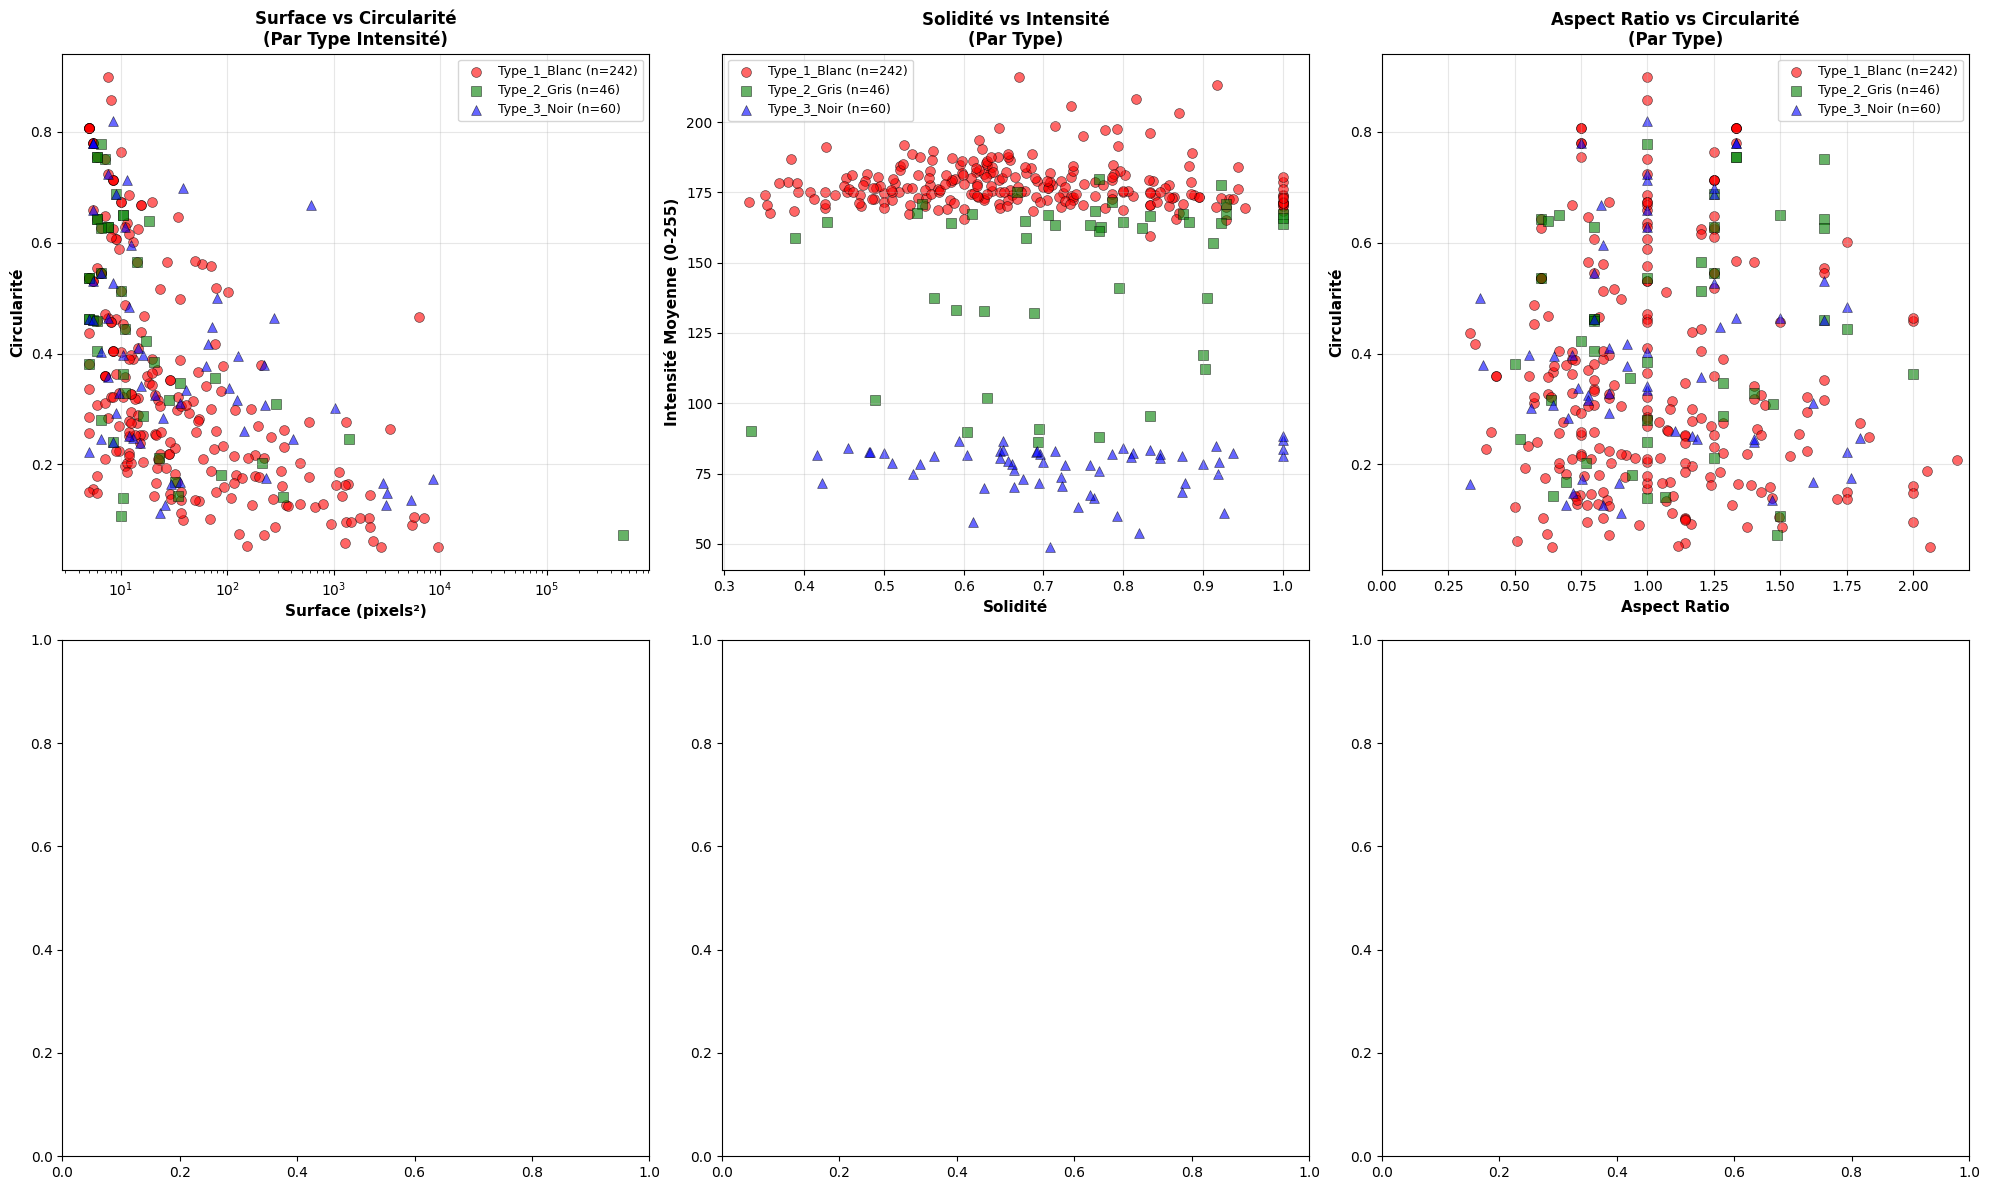

✓ Scatter plots générés


In [80]:
# Scatter plots multi-niveaux
print("\n📊 Génération des scatter plots multi-niveaux...\n")

fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# Row 1: Vue par type d'intensité
ax = axes[0, 0]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['Area_px2'], df_type['Circularity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Surface (pixels²)', fontsize=11, fontweight='bold')
ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
ax.set_title('Surface vs Circularité\n(Par Type Intensité)', fontsize=12, fontweight='bold')
ax.set_xscale('log')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 1, Col 2: Solidité vs Intensité
ax = axes[0, 1]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['Solidity'], df_type['MeanIntensity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Solidité', fontsize=11, fontweight='bold')
ax.set_ylabel('Intensité Moyenne (0-255)', fontsize=11, fontweight='bold')
ax.set_title('Solidité vs Intensité\n(Par Type)', fontsize=12, fontweight='bold')
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 1, Col 3: AspectRatio vs Circularité
ax = axes[0, 2]
for type_name, color, marker in [('Type_1_Blanc', 'red', 'o'), 
                                   ('Type_2_Gris', 'green', 's'), 
                                   ('Type_3_Noir', 'blue', '^')]:
    df_type = df_particles[df_particles['Type'] == type_name]
    if len(df_type) > 0:
        ax.scatter(df_type['AspectRatio'], df_type['Circularity'], 
                  c=color, marker=marker, s=50, alpha=0.6, 
                  edgecolors='black', linewidth=0.5,
                  label=f'{type_name} (n={len(df_type)})')

ax.set_xlabel('Aspect Ratio', fontsize=11, fontweight='bold')
ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
ax.set_title('Aspect Ratio vs Circularité\n(Par Type)', fontsize=12, fontweight='bold')
ax.set_xlim(0, min(5, df_particles['AspectRatio'].quantile(0.99)))
ax.legend(loc='best', fontsize=9)
ax.grid(True, alpha=0.3)

# Row 2: Par clusters
if 'Cluster_Combined' in df_particles.columns:
    n_clusters = df_particles['Cluster_Combined'].nunique()
    colors_clusters = plt.get_cmap('tab10')(np.linspace(0, 1, n_clusters))
    
    # Taille vs Circularité
    ax = axes[1, 0]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Size_Score'], df_cluster['Circularity'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id} (n={len(df_cluster)})')
    
    ax.set_xlabel('Taille (px²)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Circularité', fontsize=11, fontweight='bold')
    ax.set_title('TAILLE vs FORME\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Intensité vs Shape
    ax = axes[1, 1]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Intensity_Score'], df_cluster['Shape_Score'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id}')
    
    ax.set_xlabel('Intensité (0-255)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Score Forme', fontsize=11, fontweight='bold')
    ax.set_title('INTENSITÉ vs FORME\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)
    
    # Taille vs Intensité
    ax = axes[1, 2]
    for cluster_id in sorted(df_particles['Cluster_Combined'].unique()):
        df_cluster = df_particles[df_particles['Cluster_Combined'] == cluster_id]
        ax.scatter(df_cluster['Size_Score'], df_cluster['Intensity_Score'],
                  c=[colors_clusters[cluster_id]], s=50, alpha=0.6,
                  edgecolors='black', linewidth=0.5,
                  label=f'C{cluster_id}')
    
    ax.set_xlabel('Taille (px²)', fontsize=11, fontweight='bold')
    ax.set_ylabel('Intensité (0-255)', fontsize=11, fontweight='bold')
    ax.set_title('TAILLE vs INTENSITÉ\n(Clusters Combinés)', fontsize=12, fontweight='bold')
    ax.set_xscale('log')
    ax.legend(loc='best', fontsize=7, ncol=2)
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("✓ Scatter plots générés")


🔥 Génération des heatmaps...



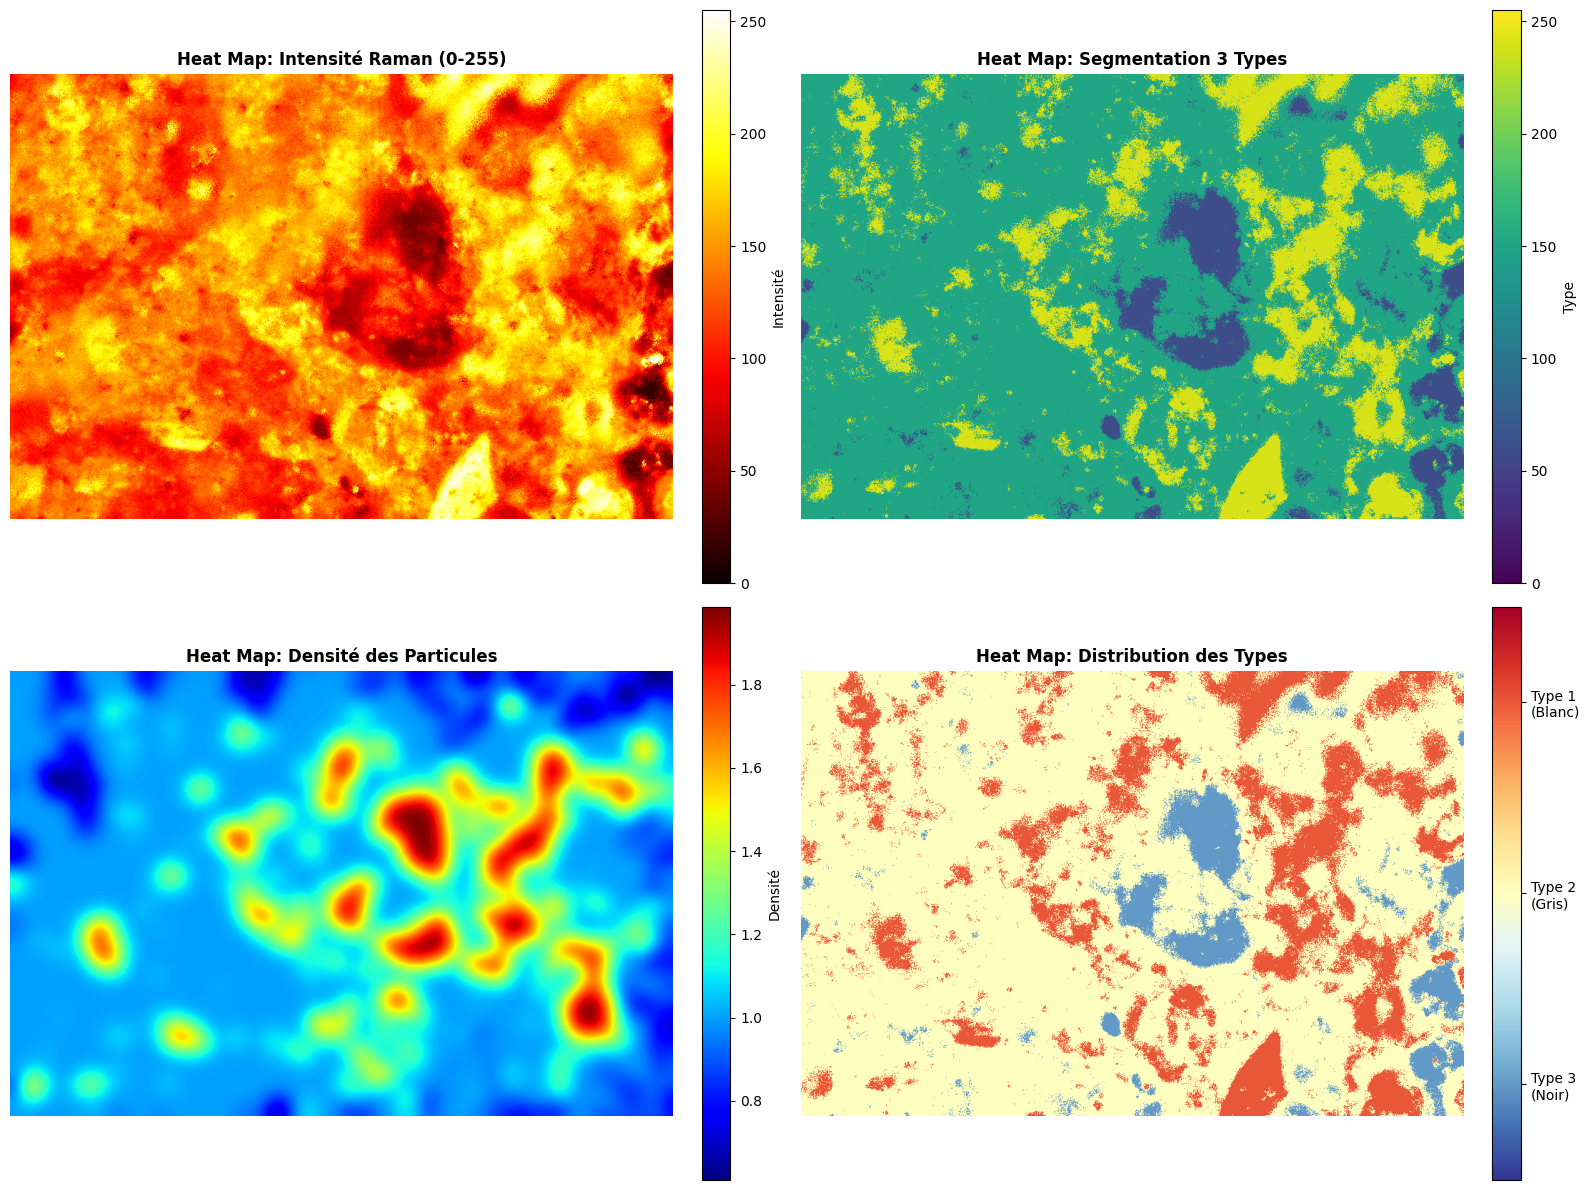

✓ Heat maps générées avec succès!


In [81]:
# Heat maps
print("\n🔥 Génération des heatmaps...\n")

# Vérifier que les masques existent
if not all(hasattr(var, '__len__') for var in [contours_type1, contours_type2, contours_type3]):
    raise ValueError("Les contours des types doivent être définis avant de générer les heatmaps")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Heatmap 1: Intensité Raman
ax = axes[0, 0]
im1 = ax.imshow(gray_eq, cmap='hot', vmin=0, vmax=255)
ax.set_title('Heat Map: Intensité Raman (0-255)', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04, label='Intensité')

# Heatmap 2: Segmentation
ax = axes[0, 1]
im2 = ax.imshow(segmentation_img, cmap='viridis', vmin=0, vmax=255)
ax.set_title('Heat Map: Segmentation 3 Types', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04, label='Type')

# Heatmap 3: Densité
ax = axes[1, 0]
density_map = np.zeros_like(gray_eq, dtype=np.float32)
for contours_list in [contours_type1, contours_type2, contours_type3]:
    for cnt in contours_list:
        mask_temp = np.zeros_like(gray_eq, dtype=np.uint8)
        cv2.drawContours(mask_temp, [cnt], -1, 1, -1)
        density_map += mask_temp

density_smooth = gaussian_filter(density_map, sigma=15)
im3 = ax.imshow(density_smooth, cmap='jet', interpolation='bilinear')
ax.set_title('Heat Map: Densité des Particules', fontsize=12, fontweight='bold')
ax.axis('off')
plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04, label='Densité')

# Heatmap 4: Distribution types
ax = axes[1, 1]
composite_map = np.zeros_like(gray_eq, dtype=np.float32)
composite_map[mask_type3] = 1.0
composite_map[mask_type2] = 2.0
composite_map[mask_type1] = 3.0

im4 = ax.imshow(composite_map, cmap='RdYlBu_r', vmin=0.5, vmax=3.5)
ax.set_title('Heat Map: Distribution des Types', fontsize=12, fontweight='bold')
ax.axis('off')
cbar4 = plt.colorbar(im4, ax=ax, fraction=0.046, pad=0.04, ticks=[1, 2, 3])
cbar4.ax.set_yticklabels(['Type 3\n(Noir)', 'Type 2\n(Gris)', 'Type 1\n(Blanc)'])

plt.tight_layout()
plt.show()

print("✓ Heat maps générées avec succès!")

## 9️⃣.1 Visualisation 3D des 3 Paramètres Combinés


🔥 GÉNÉRATION DES HEATMAPS PARAMÉTRIQUES

📏 Création de la heatmap TAILLE...
💡 Création de la heatmap INTENSITÉ...
🔺 Création de la heatmap FORME...


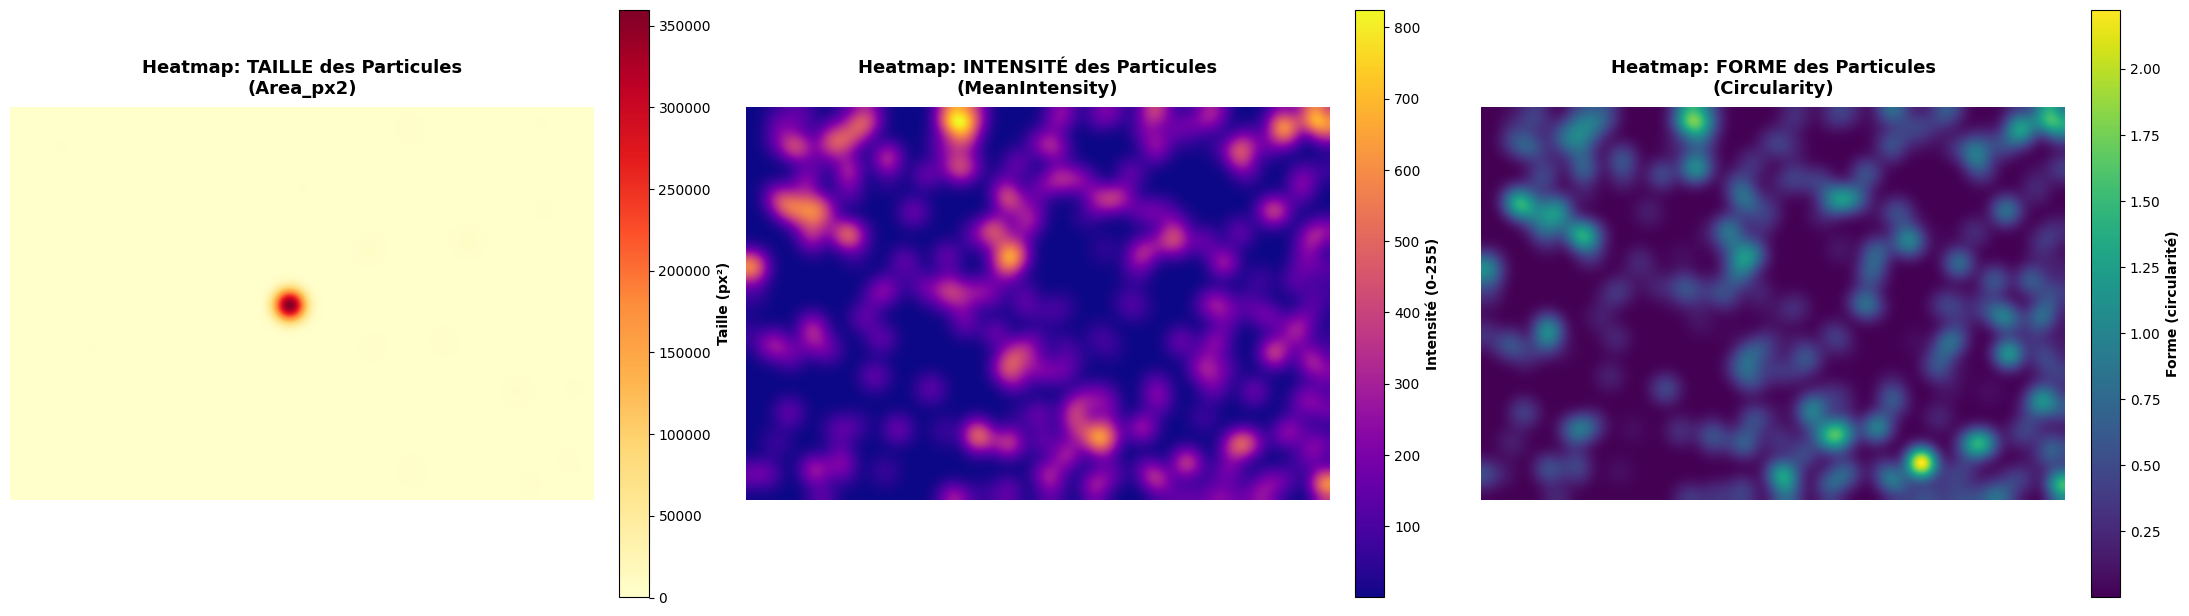


✅ HEATMAPS PARAMÉTRIQUES GÉNÉRÉES!

📊 Statistiques des heatmaps:
   Heatmap Taille:
     - Min: 0.00 | Max: 359705.75 | Moy: 1316.78
   Heatmap Intensité:
     - Min: 0.00 | Max: 824.73 | Moy: 108.96
   Heatmap Forme:
     - Min: 0.00 | Max: 2.22 | Moy: 0.26


In [82]:
print("\n🔥 GÉNÉRATION DES HEATMAPS PARAMÉTRIQUES")
print("="*80)

# Créer les heatmaps pour les 3 dimensions principales
fig, axes = plt.subplots(1, 3, figsize=(22, 7))

# Déterminer les colonnes à utiliser
size_col = 'Size_Score' if 'Size_Score' in df_particles.columns else 'Area_px2'
shape_col = 'Shape_Score' if 'Shape_Score' in df_particles.columns else 'Circularity'
intensity_col = 'Intensity_Score' if 'Intensity_Score' in df_particles.columns else 'MeanIntensity'

# HEATMAP 1: TAILLE
print("\n📏 Création de la heatmap TAILLE...")
ax = axes[0]

# Créer une carte de heatmap basée sur la taille des particules
heatmap_size = np.zeros_like(gray_eq, dtype=np.float32)
for idx, row in df_particles.iterrows():
    x, y = int(row['Center_X']), int(row['Center_Y'])
    size_value = row[size_col]
    
    # Créer un Gaussian blob centré sur la particule avec intensité basée sur la taille
    y_min, y_max = max(0, y - 30), min(gray_eq.shape[0], y + 30)
    x_min, x_max = max(0, x - 30), min(gray_eq.shape[1], x + 30)
    
    for yy in range(y_min, y_max):
        for xx in range(x_min, x_max):
            dist = np.sqrt((xx - x)**2 + (yy - y)**2)
            if dist < 30:
                weight = np.exp(-(dist**2) / (2 * 15**2))
                heatmap_size[yy, xx] += size_value * weight

heatmap_size_smooth = gaussian_filter(heatmap_size, sigma=10)
im1 = ax.imshow(heatmap_size_smooth, cmap='YlOrRd', interpolation='bilinear')
ax.set_title(f'Heatmap: TAILLE des Particules\n({size_col})', fontsize=13, fontweight='bold', pad=10)
ax.axis('off')
cbar1 = plt.colorbar(im1, ax=ax, fraction=0.046, pad=0.04)
cbar1.set_label('Taille (px²)', fontsize=10, fontweight='bold')

# HEATMAP 2: INTENSITÉ
print("💡 Création de la heatmap INTENSITÉ...")
ax = axes[1]

# Créer une carte de heatmap basée sur l'intensité
heatmap_intensity = np.zeros_like(gray_eq, dtype=np.float32)
for idx, row in df_particles.iterrows():
    x, y = int(row['Center_X']), int(row['Center_Y'])
    intensity_value = row[intensity_col]
    
    # Créer un Gaussian blob centré sur la particule avec intensité basée sur l'intensité
    y_min, y_max = max(0, y - 30), min(gray_eq.shape[0], y + 30)
    x_min, x_max = max(0, x - 30), min(gray_eq.shape[1], x + 30)
    
    for yy in range(y_min, y_max):
        for xx in range(x_min, x_max):
            dist = np.sqrt((xx - x)**2 + (yy - y)**2)
            if dist < 30:
                weight = np.exp(-(dist**2) / (2 * 15**2))
                heatmap_intensity[yy, xx] += intensity_value * weight

heatmap_intensity_smooth = gaussian_filter(heatmap_intensity, sigma=10)
im2 = ax.imshow(heatmap_intensity_smooth, cmap='plasma', interpolation='bilinear')
ax.set_title(f'Heatmap: INTENSITÉ des Particules\n({intensity_col})', fontsize=13, fontweight='bold', pad=10)
ax.axis('off')
cbar2 = plt.colorbar(im2, ax=ax, fraction=0.046, pad=0.04)
cbar2.set_label('Intensité (0-255)', fontsize=10, fontweight='bold')

# HEATMAP 3: FORME
print("🔺 Création de la heatmap FORME...")
ax = axes[2]

# Créer une carte de heatmap basée sur la forme (circularité/compacité)
heatmap_shape = np.zeros_like(gray_eq, dtype=np.float32)
for idx, row in df_particles.iterrows():
    x, y = int(row['Center_X']), int(row['Center_Y'])
    shape_value = row[shape_col]
    
    # Créer un Gaussian blob centré sur la particule avec intensité basée sur la forme
    y_min, y_max = max(0, y - 30), min(gray_eq.shape[0], y + 30)
    x_min, x_max = max(0, x - 30), min(gray_eq.shape[1], x + 30)
    
    for yy in range(y_min, y_max):
        for xx in range(x_min, x_max):
            dist = np.sqrt((xx - x)**2 + (yy - y)**2)
            if dist < 30:
                weight = np.exp(-(dist**2) / (2 * 15**2))
                heatmap_shape[yy, xx] += shape_value * weight

heatmap_shape_smooth = gaussian_filter(heatmap_shape, sigma=10)
im3 = ax.imshow(heatmap_shape_smooth, cmap='viridis', interpolation='bilinear')
ax.set_title(f'Heatmap: FORME des Particules\n({shape_col})', fontsize=13, fontweight='bold', pad=10)
ax.axis('off')
cbar3 = plt.colorbar(im3, ax=ax, fraction=0.046, pad=0.04)
cbar3.set_label('Forme (circularité)', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.savefig('heatmaps_parametriques_3d.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.show()

print("\n" + "="*80)
print("✅ HEATMAPS PARAMÉTRIQUES GÉNÉRÉES!")
print("="*80)
print(f"\n📊 Statistiques des heatmaps:")
print(f"   Heatmap Taille:")
print(f"     - Min: {heatmap_size_smooth.min():.2f} | Max: {heatmap_size_smooth.max():.2f} | Moy: {heatmap_size_smooth.mean():.2f}")
print(f"   Heatmap Intensité:")
print(f"     - Min: {heatmap_intensity_smooth.min():.2f} | Max: {heatmap_intensity_smooth.max():.2f} | Moy: {heatmap_intensity_smooth.mean():.2f}")
print(f"   Heatmap Forme:")
print(f"     - Min: {heatmap_shape_smooth.min():.2f} | Max: {heatmap_shape_smooth.max():.2f} | Moy: {heatmap_shape_smooth.mean():.2f}")

In [83]:
print("\n📐 Génération de la visualisation 3D combinée...")

if 'Cluster_Combined' in df_particles.columns:
    fig = plt.figure(figsize=(18, 6))
    
    # Vue 1: Clusters combinés dans l'espace 3D
    ax1 = fig.add_subplot(131, projection='3d')
    scatter1 = ax1.scatter(df_particles['Size_Normalized'].values, 
                          df_particles['Shape_Normalized'].values,
                          df_particles['Intensity_Normalized'].values,
                          c=df_particles['Cluster_Combined'].values, 
                          cmap='tab10', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
    ax1.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
    ax1.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
    ax1.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
    ax1.set_title('Espace 3D Combiné\n(Clusters Multi-Paramètres)', fontsize=11, fontweight='bold')
    plt.colorbar(scatter1, ax=ax1, label='Cluster ID', shrink=0.6, pad=0.1)
    
    # Vue 2: Clusters 3D purs
    if 'Cluster_3D' in df_particles.columns:
        ax2 = fig.add_subplot(132, projection='3d')
        scatter2 = ax2.scatter(df_particles['Size_Normalized'].values, 
                              df_particles['Shape_Normalized'].values,
                              df_particles['Intensity_Normalized'].values,
                              c=df_particles['Cluster_3D'].values, 
                              cmap='viridis', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
        ax2.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
        ax2.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
        ax2.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
        ax2.set_title('Clustering 3D Pur\n(Espace Normalisé)', fontsize=11, fontweight='bold')
        plt.colorbar(scatter2, ax=ax2, label='Cluster 3D', shrink=0.6, pad=0.1)
    
    # Vue 3: Types de particules physiques
    if 'Particle_Type_Combined' in df_particles.columns:
        ax3 = fig.add_subplot(133, projection='3d')
        
        # Mapper les types à des couleurs
        unique_types = df_particles['Particle_Type_Combined'].unique()
        type_to_num = {t: i for i, t in enumerate(unique_types)}
        color_nums = df_particles['Particle_Type_Combined'].map(type_to_num)
        
        scatter3 = ax3.scatter(df_particles['Size_Normalized'].values, 
                              df_particles['Shape_Normalized'].values,
                              df_particles['Intensity_Normalized'].values,
                              c=color_nums.values, 
                              cmap='Set3', s=30, alpha=0.6, edgecolors='black', linewidth=0.3)
        ax3.set_xlabel('TAILLE\n(normalisée)', fontsize=9, fontweight='bold')
        ax3.set_ylabel('FORME\n(score)', fontsize=9, fontweight='bold')
        ax3.set_zlabel('INTENSITÉ\n(normalisée)', fontsize=9, fontweight='bold')
        ax3.set_title('Types Physiques\n(Classification Combinée)', fontsize=11, fontweight='bold')
    
    plt.tight_layout()
    plt.show()
    
    print("✓ Visualisation 3D combinée générée")


📐 Génération de la visualisation 3D combinée...


## 9️⃣.2 Histogramme des Intensités avec Seuils


📊 Génération de l'histogramme des intensités...


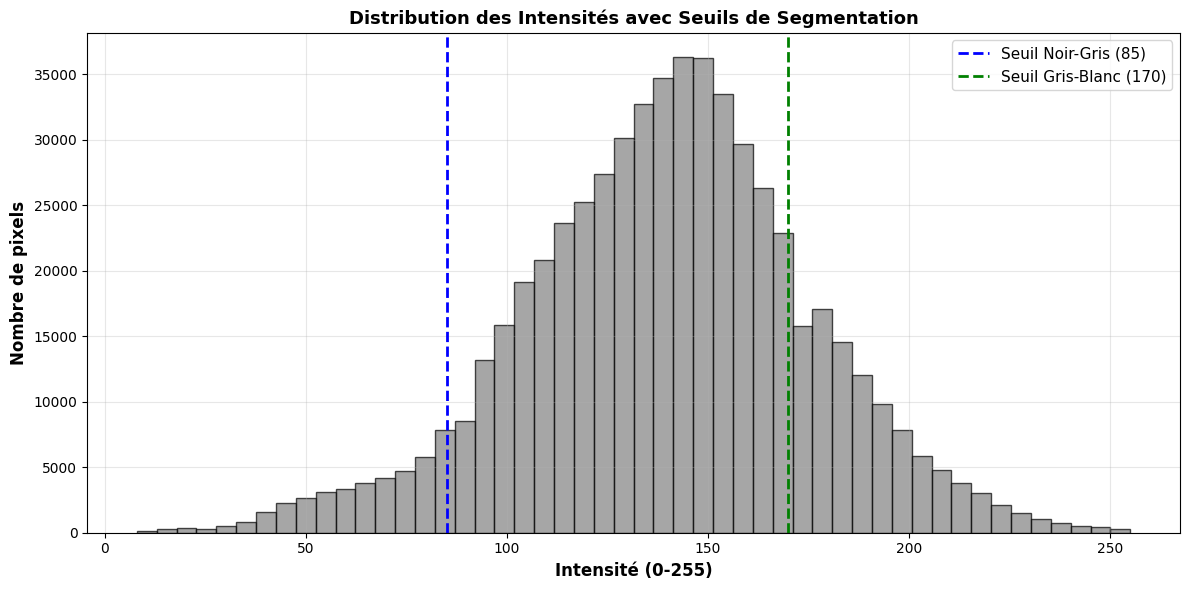

✓ Histogramme des intensités généré


In [84]:
print("\n📊 Génération de l'histogramme des intensités...")

fig, ax = plt.subplots(figsize=(12, 6))
ax.hist(gray_eq.ravel(), bins=50, color='gray', alpha=0.7, edgecolor='black')
ax.axvline(thresh1, color='blue', linestyle='--', linewidth=2, label=f'Seuil Noir-Gris ({thresh1})')
ax.axvline(thresh2, color='green', linestyle='--', linewidth=2, label=f'Seuil Gris-Blanc ({thresh2})')
ax.set_xlabel('Intensité (0-255)', fontweight='bold', fontsize=12)
ax.set_ylabel('Nombre de pixels', fontweight='bold', fontsize=12)
ax.set_title('Distribution des Intensités avec Seuils de Segmentation', fontsize=13, fontweight='bold')
ax.legend(fontsize=11)
ax.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("✓ Histogramme des intensités généré")

## 🔟 Rapport Final et Sauvegarde des Résultats

In [85]:
print("\n" + "="*80)
print("📋 RAPPORT FINAL - CLUSTERING COMBINÉ (TAILLE × FORME × INTENSITÉ)")
print("="*80)

print(f"\n📊 DONNÉES GÉNÉRALES:")
print(f"  Total particules détectées: {len(df_particles)}")
print(f"  Dimensions image: {gray.shape}")
print(f"  Clusters identifiés: {n_main_clusters}")
print(f"  Types de particules uniques: {df_particles['Particle_Type_Combined'].nunique() if 'Particle_Type_Combined' in df_particles.columns else 'N/A'}")

print(f"\n🔬 SEGMENTATION INITIALE PAR INTENSITÉ:")
for type_name in ['Type_1_Blanc', 'Type_2_Gris', 'Type_3_Noir']:
    if 'Type' in df_particles.columns:
        count = len(df_particles[df_particles['Type'] == type_name])
        pct = 100 * count / len(df_particles) if len(df_particles) > 0 else 0
        
        # Utiliser Size_Score si disponible, sinon Area_px2
        size_col = 'Size_Score' if 'Size_Score' in df_particles.columns else 'Area_px2'
        avg_size = df_particles[df_particles['Type'] == type_name][size_col].mean()
        
        print(f"  {type_name}: {count} particules ({pct:.1f}%) - Taille moy: {avg_size:.1f} px²")

print(f"\n🎯 CLUSTERING COMBINÉ MULTI-PARAMÈTRES:")
print(f"  Nombre de clusters: {n_main_clusters}")
print(f"  Méthode: KMeans avec pondération (Taille + Forme + Intensité)")

if 'Cluster_3D' in df_particles.columns or 'n_3d_clusters' in dir():
    print(f"\n📐 CLUSTERING 3D:")
    print(f"  Nombre de clusters 3D: {n_3d_clusters if 'n_3d_clusters' in dir() else 'N/A'}")

print(f"\n🏷️ CLASSIFICATION PHYSIQUE COMBINÉE:")
if 'Particle_Type_Combined' in df_particles.columns:
    print(f"  Types uniques identifiés: {df_particles['Particle_Type_Combined'].nunique()}")
    print(f"\n  Top 10 types:")
    for idx, (ptype, count) in enumerate(df_particles['Particle_Type_Combined'].value_counts().head(10).items(), 1):
        pct = 100 * count / len(df_particles)
        print(f"    {idx:2d}. {ptype}: {count:3d} ({pct:5.1f}%)")
else:
    print(f"  Classification Particle_Type_Combined non disponible")

print(f"\n📈 STATISTIQUES DES PROPRIÉTÉS MORPHOLOGIQUES:")

# Taille
size_col = 'Size_Score' if 'Size_Score' in df_particles.columns else 'Area_px2'
print(f"  TAILLE ({size_col}):")
print(f"    Min: {df_particles[size_col].min():.1f} px²")
print(f"    Max: {df_particles[size_col].max():.1f} px²")
print(f"    Moyenne: {df_particles[size_col].mean():.1f} px²")
print(f"    Médiane: {df_particles[size_col].median():.1f} px²")

# Forme
shape_col = 'Shape_Score' if 'Shape_Score' in df_particles.columns else 'Circularity'
print(f"\n  FORME ({shape_col}):")
if shape_col in df_particles.columns:
    print(f"    Min: {df_particles[shape_col].min():.3f}")
    print(f"    Max: {df_particles[shape_col].max():.3f}")
    print(f"    Moyenne: {df_particles[shape_col].mean():.3f}")

# Intensité
intensity_col = 'Intensity_Score' if 'Intensity_Score' in df_particles.columns else 'MeanIntensity'
print(f"\n  INTENSITÉ ({intensity_col}):")
if intensity_col in df_particles.columns:
    print(f"    Min: {df_particles[intensity_col].min():.1f}/255")
    print(f"    Max: {df_particles[intensity_col].max():.1f}/255")
    print(f"    Moyenne: {df_particles[intensity_col].mean():.1f}/255")

print("\n" + "="*80)
print("✅ ANALYSE STATISTIQUE COMPLÈTE TERMINÉE!")
print("="*80)


📋 RAPPORT FINAL - CLUSTERING COMBINÉ (TAILLE × FORME × INTENSITÉ)

📊 DONNÉES GÉNÉRALES:
  Total particules détectées: 348
  Dimensions image: (624, 928)
  Clusters identifiés: 10
  Types de particules uniques: 9

🔬 SEGMENTATION INITIALE PAR INTENSITÉ:
  Type_1_Blanc: 242 particules (69.5%) - Taille moy: 315.8 px²
  Type_2_Gris: 46 particules (13.2%) - Taille moy: 11365.7 px²
  Type_3_Noir: 60 particules (17.2%) - Taille moy: 456.2 px²

🎯 CLUSTERING COMBINÉ MULTI-PARAMÈTRES:
  Nombre de clusters: 10
  Méthode: KMeans avec pondération (Taille + Forme + Intensité)

📐 CLUSTERING 3D:
  Nombre de clusters 3D: 10

🏷️ CLASSIFICATION PHYSIQUE COMBINÉE:
  Types uniques identifiés: 9

  Top 10 types:
     1. Blanc_Petit_Anguleux: 162 ( 46.6%)
     2. Gris_Petit_Anguleux:  53 ( 15.2%)
     3. Blanc_Grand_Anguleux:  48 ( 13.8%)
     4. Noir_Petit_Anguleux:  40 ( 11.5%)
     5. Blanc_Petit_Rond:  16 (  4.6%)
     6. Noir_Grand_Anguleux:  12 (  3.4%)
     7. Gris_Petit_Rond:   8 (  2.3%)
     8. Gri

In [86]:
# Sauvegarder tous les résultats
print("\n💾 SAUVEGARDE DES RÉSULTATS...")
print("="*80)

# 1. Données principales
df_particles.to_csv("particles_by_intensity_types.csv", index=False)
print("✓ particles_by_intensity_types.csv")

# 2. Résumés clustering
# Déterminer quelle colonne de cluster utiliser
cluster_col_available = None
if 'Cluster_Combined' in df_particles.columns:
    cluster_col_available = 'Cluster_Combined'
elif 'Cluster_3D' in df_particles.columns:
    cluster_col_available = 'Cluster_3D'
elif 'Cluster' in df_particles.columns:
    cluster_col_available = 'Cluster'

if cluster_col_available and 'Size_Score' in df_particles.columns:
    try:
        cluster_combined_summary = df_particles.groupby(cluster_col_available).agg({
            'Size_Score': ['count', 'mean', 'std'],
            'Shape_Score': ['mean', 'std'] if 'Shape_Score' in df_particles.columns else {},
            'Intensity_Score': ['mean', 'std'] if 'Intensity_Score' in df_particles.columns else {}
        }).round(3)
        # Nettoyer les colonnes vides
        cluster_combined_summary = cluster_combined_summary.dropna(axis=1, how='all')
        cluster_combined_summary.to_csv("cluster_combined_summary.csv")
        print(f"✓ cluster_combined_summary.csv (basé sur {cluster_col_available})")
    except Exception as e:
        print(f"⚠️ Impossible de créer cluster_combined_summary.csv: {str(e)}")

if 'Cluster_3D' in df_particles.columns:
    try:
        size_norm_col = 'Size_Normalized' if 'Size_Normalized' in df_particles.columns else 'Area_px2'
        shape_norm_col = 'Shape_Normalized' if 'Shape_Normalized' in df_particles.columns else 'Circularity'
        intensity_norm_col = 'Intensity_Normalized' if 'Intensity_Normalized' in df_particles.columns else 'MeanIntensity'
        
        cluster_3d_summary = df_particles.groupby('Cluster_3D').agg({
            size_norm_col: ['count', 'mean', 'std'],
            shape_norm_col: ['mean', 'std'],
            intensity_norm_col: ['mean', 'std']
        }).round(4)
        cluster_3d_summary.to_csv("cluster_3d_summary.csv")
        print("✓ cluster_3d_summary.csv")
    except Exception as e:
        print(f"⚠️ Impossible de créer cluster_3d_summary.csv: {str(e)}")

# 3. Distributions
if 'Particle_Type_Combined' in df_particles.columns:
    particle_type_distribution = df_particles['Particle_Type_Combined'].value_counts()
    particle_type_distribution.to_csv("particle_types_combined_distribution.csv", header=['Count'])
    print("✓ particle_types_combined_distribution.csv")

# 4. Matrices de confusion
if 'Particle_Type_Combined' in df_particles.columns and 'Type' in df_particles.columns:
    try:
        confusion_matrix = pd.crosstab(
            df_particles['Type'], 
            df_particles['Particle_Type_Combined'],
            margins=True,
            margins_name='TOTAL'
        )
        confusion_matrix.to_csv("confusion_matrix_types.csv")
        print("✓ confusion_matrix_types.csv")
    except Exception as e:
        print(f"⚠️ Impossible de créer confusion_matrix_types.csv: {str(e)}")

# 5. Tableaux croisés
if cluster_col_available and 'Type' in df_particles.columns:
    try:
        crosstab_intensity = pd.crosstab(
            df_particles[cluster_col_available],
            df_particles['Type']
        )
        crosstab_intensity.to_csv("crosstab_clusters_vs_intensity.csv")
        print(f"✓ crosstab_clusters_vs_intensity.csv")
    except Exception as e:
        print(f"⚠️ Impossible de créer crosstab_clusters_vs_intensity.csv: {str(e)}")

# 6. Résultats PCA
if 'PCA_1' in df_particles.columns and 'PCA_2' in df_particles.columns and 'PCA_3' in df_particles.columns:
    try:
        pca_data = {
            'PCA_1': df_particles['PCA_1'],
            'PCA_2': df_particles['PCA_2'],
            'PCA_3': df_particles['PCA_3']
        }
        
        if cluster_col_available:
            pca_data[cluster_col_available] = df_particles[cluster_col_available]
        
        if 'Type' in df_particles.columns:
            pca_data['Type'] = df_particles['Type']
        
        pca_results = pd.DataFrame(pca_data)
        pca_results.to_csv("pca_3d_results.csv", index=False)
        print("✓ pca_3d_results.csv")
    except Exception as e:
        print(f"⚠️ Impossible de créer pca_3d_results.csv: {str(e)}")

# 7. Zone équilibrée
if 'x_center' in dir() and 'y_center' in dir() and 'x_topleft' in dir() and 'y_topleft' in dir():
    try:
        zone_info_save = {
            'Center_X': x_center,
            'Center_Y': y_center,
            'TopLeft_X': x_topleft,
            'TopLeft_Y': y_topleft,
            'Window_Size': square_size,
            'Total_Particles': best_window['n_particles'] if 'best_window' in dir() else len(df_particles),
            'Total_Clusters': total_clusters if 'total_clusters' in dir() else df_particles[cluster_col_available].nunique() if cluster_col_available else 0
        }
        
        if cluster_col_available and 'region_cluster_counts' in dir():
            for cluster_id in sorted(df_particles[cluster_col_available].unique()):
                count = region_cluster_counts.get(cluster_id, 0)
                zone_info_save[f'Cluster_{cluster_id}_Count'] = count
        
        zone_info_df = pd.DataFrame([zone_info_save])
        zone_info_df.to_csv("zone_equilibree_info.csv", index=False)
        print("✓ zone_equilibree_info.csv")
    except Exception as e:
        print(f"⚠️ Impossible de créer zone_equilibree_info.csv: {str(e)}")

# 8. Meilleur échantillon
if 'best_window' in dir() and 'x_center' in dir():
    try:
        best_sample_info = {
            'Center_X': x_center,
            'Center_Y': y_center,
            'Total_Clusters': total_clusters if 'total_clusters' in dir() else 0,
            'Total_Particles_In_Zone': best_window['n_particles'],
            'Window_Size_px': square_size,
            'All_Clusters_Present': 'YES' if 'total_clusters' in dir() and best_window.get('clusters', 0) == total_clusters else 'PARTIAL'
        }
        best_sample_df = pd.DataFrame([best_sample_info])
        best_sample_df.to_csv("best_representative_sample.csv", index=False)
        print("✓ best_representative_sample.csv")
    except Exception as e:
        print(f"⚠️ Impossible de créer best_representative_sample.csv: {str(e)}")

print("\n" + "="*80)
print("✅ SAUVEGARDE DES RÉSULTATS TERMINÉE!")
print("="*80)


💾 SAUVEGARDE DES RÉSULTATS...
✓ particles_by_intensity_types.csv
✓ particle_types_combined_distribution.csv
✓ confusion_matrix_types.csv
✓ crosstab_clusters_vs_intensity.csv
✓ pca_3d_results.csv
✓ zone_equilibree_info.csv
✓ best_representative_sample.csv

✅ SAUVEGARDE DES RÉSULTATS TERMINÉE!
